In [1]:
import numpy as np
import pandas as pd
import pickle
import os 
from load_data import convert

import matplotlib.pyplot as plt
%matplotlib inline 

path = '/nmnt/x01-hdd/adni_data/'

In [2]:
with open(path + 'subj_idx', 'rb') as f:
    subj_idx = pickle.load(f)

In [3]:
subj_idx.shape

(125,)

In [4]:
with open('/nmnt/x01-hdd/HCP/data/mean_mesh_labels', 'rb') as f:
    labels = pickle.load(f)
labels = labels.reshape(-1)

In [6]:
path_matrices = path + 'matrices/' 
all_data = pd.DataFrame(columns = ['subject_id_file', 'subject_name', 'matrix','thickness', 'target'])


for foldername in sorted(os.listdir(path_matrices)):
    if foldername[:-2] in subj_idx:
        for filename in sorted(os.listdir(path_matrices+foldername)):
            if 'NORM' not in filename:
                mat = np.genfromtxt(path_matrices+foldername+'/'+filename)
                subject_id_file = foldername
                
                mat = np.delete(mat, [3,38], 1) 
                mat = np.delete(mat, [3,38], 0)

                subject_data = convert(mat, mode = 'mat2vec')
                single_subject = pd.DataFrame(data = [[subject_id_file, subject_id_file[:-2], subject_data, np.nan, np.nan]],
                                              columns = ['subject_id_file','subject_name', 'matrix', 'thickness', 'target'])
                all_data = all_data.append(single_subject)
path_subject_id = path + 'ADNI2_Master_Subject_List.xls'
subject_data = pd.read_excel(path_subject_id, sheetname = 'Subject List')
all_data.index = all_data.subject_id_file
subject_id_names = np.array(all_data['subject_id_file'])
for name in subject_id_names:
    smth = subject_data.loc[subject_data['Subject ID'] == name[:-2]]['DX Group'].dropna()
    un_smth = np.unique(smth)
    try:
        val = un_smth[0].replace(' ', '')
        all_data.set_value(name, 'target', val)
    except:
        print('smth with ', name )
        pass
path_thickness = path + 'thickness/'
for name in subject_id_names:
        tmp = []
        with open(path_thickness + name[:-2] + '/' + 'LH_thick_smooth_2e-4.raw', 'rb') as f:
                t = np.fromfile(f, count=-1 ,dtype='float32')
                t = np.where(t < 0, 0, t)
                tmp += [t]
        with open(path_thickness + name[:-2] + '/' + 'RH_thick_smooth_2e-4.raw', 'rb') as f:
                t = np.fromfile(f, count=-1 ,dtype='float32')
                t = np.where(t < 0, 0, t)
                tmp += [t]
        tmp = np.array(tmp).reshape(-1)
        try:
            all_data.set_value(name, 'thickness', tmp)
        except:
            pass


smth with  021_S_5099_1
smth with  021_S_5129_1
smth with  021_S_5236_2
smth with  057_S_5292_1
smth with  099_S_4157_5
smth with  099_S_4205_5
smth with  099_S_4463_1


In [7]:
all_data = all_data.drop(all_data[all_data.target == 'SMC'].index)

In [8]:
Normal = all_data[all_data.target == 'Normal']
AD = all_data[all_data.target == 'AD']
EMCI = all_data[all_data.target == 'EMCI']
LMCI = all_data[all_data.target == 'LMCI']
print(Normal.shape, AD.shape, EMCI.shape, LMCI.shape)

(99, 5) (87, 5) (64, 5) (87, 5)


In [9]:
Normal = Normal.sort_values(by = 'subject_id_file')
AD = AD.sort_values(by = 'subject_id_file')
EMCI = EMCI.sort_values(by = 'subject_id_file')
LMCI = LMCI.sort_values(by = 'subject_id_file')

In [10]:
print(np.unique(Normal.subject_name).shape,np.unique(AD.subject_name).shape,
      np.unique(EMCI.subject_name).shape, np.unique(LMCI.subject_name).shape)

(30,) (29,) (16,) (23,)


In [11]:
Normal = Normal.drop_duplicates('subject_name')
AD = AD.drop_duplicates('subject_name')
EMCI = EMCI.drop_duplicates('subject_name')
LMCI = LMCI.drop_duplicates('subject_name')
print(Normal.shape, AD.shape, EMCI.shape, LMCI.shape)

(30, 5) (29, 5) (16, 5) (23, 5)


In [12]:
NC_y = np.array([convert(Normal.matrix[i]) for i in range(Normal.shape[0])])
NC_wdeg = NC_y.sum(axis = -1)
AD_y = np.array([convert(AD.matrix[i]) for i in range(AD.shape[0])])
AD_wdeg = AD_y.sum(axis = -1)
EMCI_y = np.array([convert(EMCI.matrix[i]) for i in range(EMCI.shape[0])])
EMCI_wdeg = EMCI_y.sum(axis = -1)
LMCI_y = np.array([convert(LMCI.matrix[i]) for i in range(LMCI.shape[0])])
LMCI_wdeg = LMCI_y.sum(axis = -1)

In [14]:
nodes = np.unique(labels)
res = []
NC_thick = np.array([np.array(Normal.thickness)[i] for i in range(Normal.shape[0])])
print(NC_thick.shape)
NC_thick_mean = []
NC_thick_median = []
NC_thick_quant = []
for one in nodes:
    if one != 0:
        idx = np.where(labels == one)[0]
        NC_thick_mean  += [np.mean(NC_thick[:,idx], axis = -1)]
        NC_thick_median += [np.median(NC_thick[:, idx], axis = -1)]
        NC_thick_quant += [np.percentile(NC_thick[:, idx], q = 75,axis = -1) - \
                           np.percentile(NC_thick[:, idx], q = 25,axis = -1)]
        

NC_thick_mean = np.array(NC_thick_mean).T
NC_thick_median = np.array(NC_thick_median).T
NC_thick_quant = np.array(NC_thick_quant).T

(30, 327684)


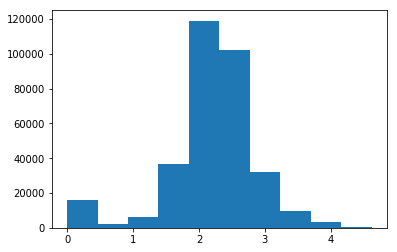

In [15]:
plt.hist(NC_thick.mean(axis = 0));

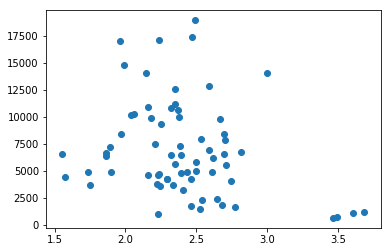

In [16]:
plt.scatter(NC_thick_mean.mean(axis = 0), NC_wdeg.mean(axis = 0))

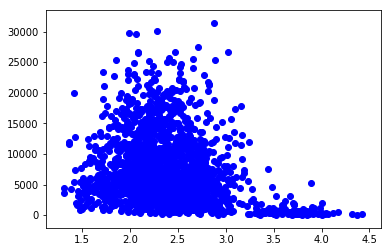

In [17]:
for i in range(Normal.shape[0]):
    plt.scatter(NC_thick_mean[i,:], NC_wdeg[i,:],c = 'b')


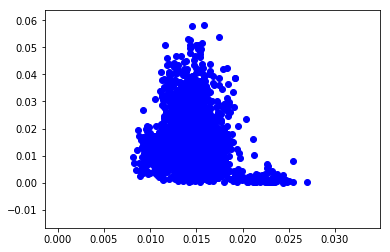

In [18]:
for i in range(Normal.shape[0]):
    plt.scatter(NC_thick_mean[i,:]/np.sum(NC_thick_mean[i,:]), NC_wdeg[i,:]/np.sum(NC_wdeg[i,:]),c = 'b')


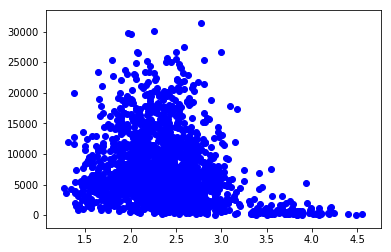

In [19]:
for i in range(Normal.shape[0]):
    plt.scatter(NC_thick_median[i,:], NC_wdeg[i,:],c = 'b')


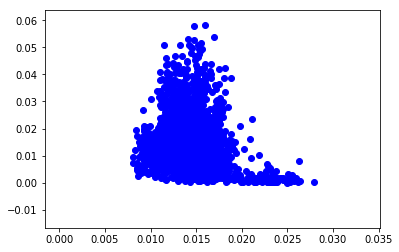

In [20]:
for i in range(Normal.shape[0]):
    plt.scatter(NC_thick_median[i,:]/np.sum(NC_thick_median[i,:]), NC_wdeg[i,:]/np.sum(NC_wdeg[i,:]),c = 'b')


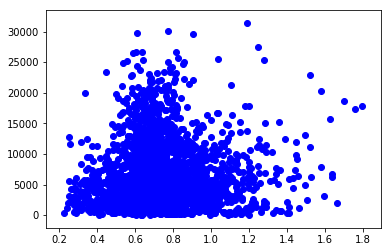

In [21]:
for i in range(Normal.shape[0]):
    plt.scatter(NC_thick_quant[i,:], NC_wdeg[i,:],c = 'b')


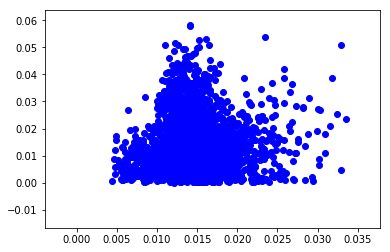

In [22]:
for i in range(Normal.shape[0]):
    plt.scatter(NC_thick_quant[i,:]/np.sum(NC_thick_quant[i,:]), NC_wdeg[i,:]/np.sum(NC_wdeg[i,:]),c = 'b')


In [23]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

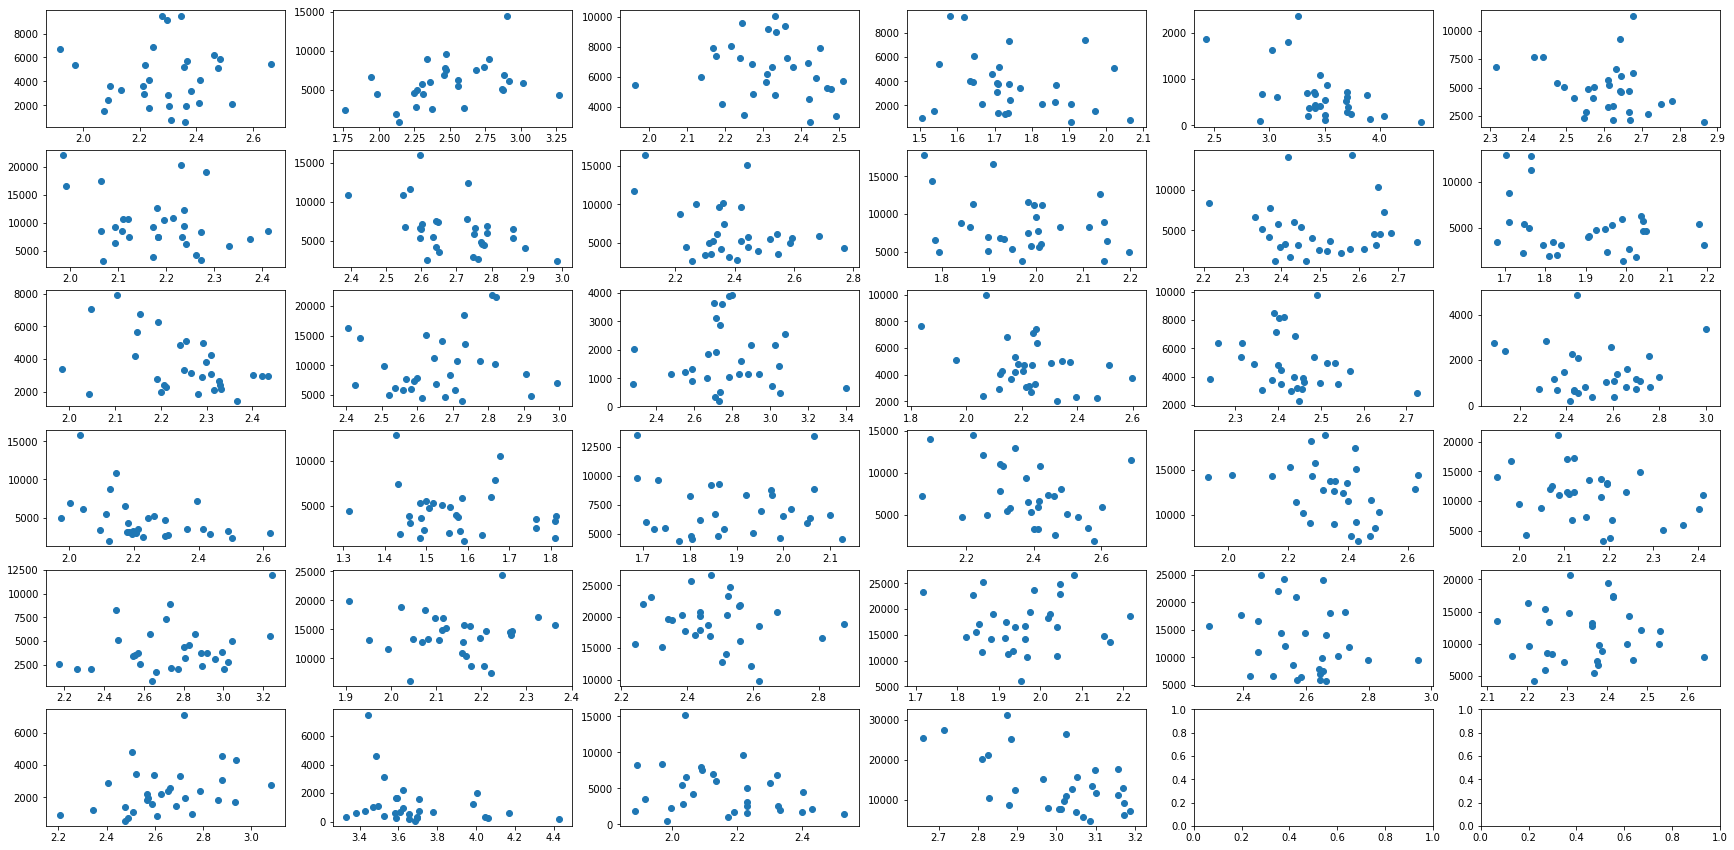

In [24]:
idx = np.arange(36).reshape(6,6)
fig, ax = plt.subplots(6,6, figsize = (30,15))
for i in range(6):
    for j in range(6):
        if i == 5:
            if j == 4:
                break
        ax[i, j].scatter(NC_thick_mean[:, idx[i,j]], NC_wdeg[:,idx[i,j]])
#         ax[i, j].set_xlim([0.01, 0.02])

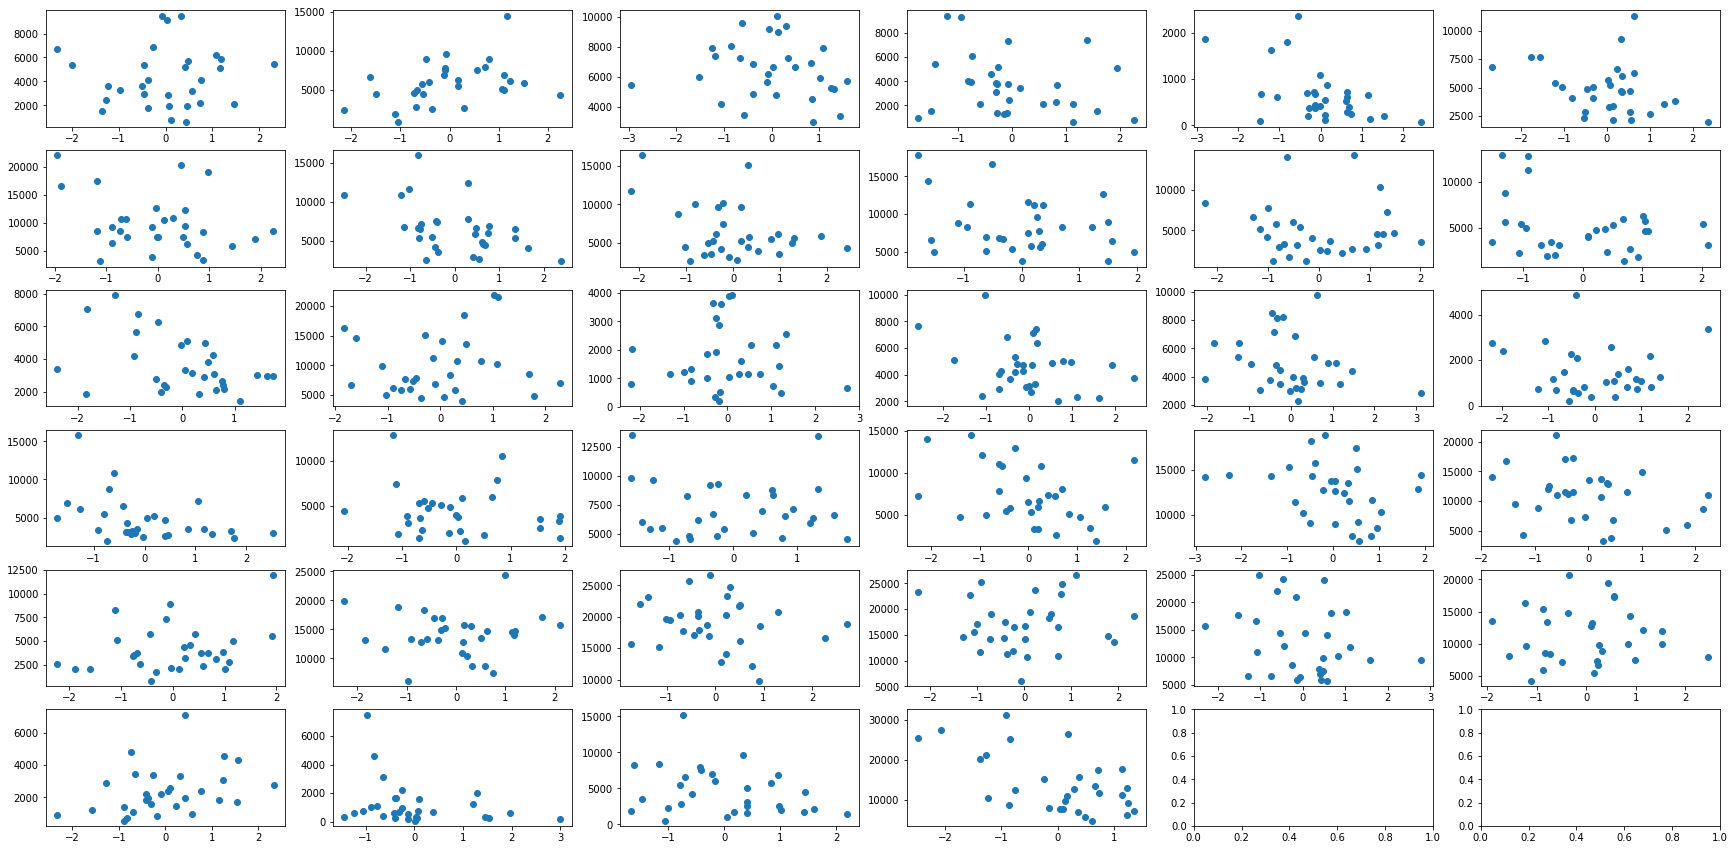

In [25]:
idx = np.arange(36).reshape(6,6)
st_NC_thick_mean = sc.fit_transform(NC_thick_mean)
fig, ax = plt.subplots(6,6, figsize = (30,15))
for i in range(6):
    for j in range(6):
        if i == 5:
            if j == 4:
                break
        ax[i, j].scatter(st_NC_thick_mean[:, idx[i,j]], NC_wdeg[:,idx[i,j]])
#         ax[i, j].set_xlim([0.01, 0.02])

In [26]:
from scipy.stats import spearmanr

In [27]:
NC_corr = np.array([spearmanr(NC_thick_mean[i,:], NC_wdeg[i,:]) for i in range(30)])
NC_corr

array([[-0.15471237,  0.20776364],
       [-0.27682559,  0.02229529],
       [-0.17669962,  0.14945543],
       [-0.3508417 ,  0.00335343],
       [-0.34530671,  0.00392711],
       [-0.24384704,  0.0450814 ],
       [-0.3278238 ,  0.00635185],
       [-0.21506279,  0.07819672],
       [-0.21017674,  0.08537755],
       [-0.16456083,  0.17991807],
       [-0.26514486,  0.02887585],
       [-0.30858495,  0.01045838],
       [-0.17488811,  0.15373951],
       [-0.23705004,  0.05161111],
       [-0.16311028,  0.1838397 ],
       [-0.32202161,  0.00740707],
       [-0.19674008,  0.10782613],
       [-0.25575448,  0.03528674],
       [-0.22945375,  0.05980319],
       [-0.23426347,  0.05450262],
       [-0.13085468,  0.28749575],
       [-0.34389434,  0.00408678],
       [-0.20040463,  0.10129443],
       [-0.15024621,  0.22134937],
       [-0.28785739,  0.01729643],
       [-0.12123526,  0.32470495],
       [-0.12192236,  0.32194989],
       [-0.29293431,  0.01533997],
       [-0.30973012,

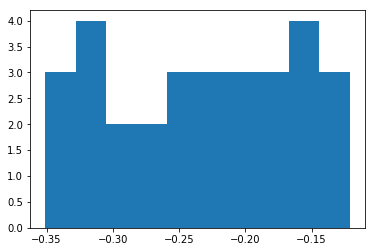

In [29]:
plt.hist(NC_corr[:,0]);

In [30]:
nodes = np.unique(labels)
res = []
AD_thick = np.array([np.array(AD.thickness)[i] for i in range(AD.shape[0])])
print(AD_thick.shape)
AD_thick_mean = []
AD_thick_median = []
AD_thick_quant = []
for one in nodes:
    if one != 0:
        idx = np.where(labels == one)[0]
        AD_thick_mean  += [np.mean(AD_thick[:,idx], axis = -1)]
        AD_thick_median += [np.median(AD_thick[:, idx], axis = -1)]
        AD_thick_quant += [np.percentile(AD_thick[:, idx], q = 95,axis = -1) - np.percentile(AD_thick[:, idx], q = 5,axis = -1)]
        

AD_thick_mean = np.array(AD_thick_mean).T
AD_thick_median = np.array(AD_thick_median).T
AD_thick_quant = np.array(AD_thick_quant).T

(29, 327684)


In [31]:
AD_thick_mean.shape, AD_wdeg.shape

((29, 68), (29, 68))

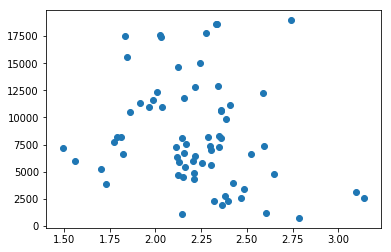

In [32]:
plt.scatter(AD_thick_mean.mean(axis = 0), AD_wdeg.mean(axis = 0))

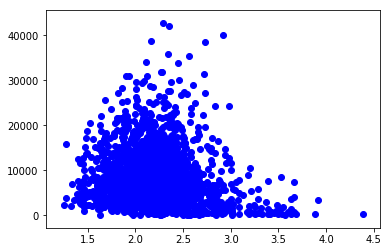

In [33]:
for i in range(AD.shape[0]):
    plt.scatter(AD_thick_mean[i,:], AD_wdeg[i,:],c = 'b')

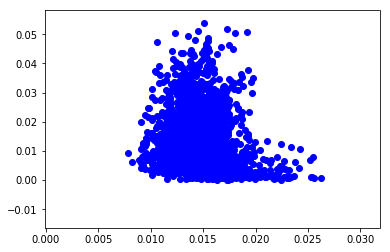

In [34]:
for i in range(AD.shape[0]):
    plt.scatter(AD_thick_mean[i,:]/np.sum(AD_thick_mean[i,:]), AD_wdeg[i,:]/np.sum(AD_wdeg[i,:]),c = 'b')

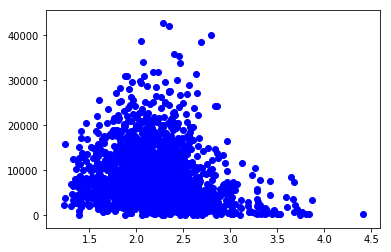

In [35]:
for i in range(AD.shape[0]):
    plt.scatter(AD_thick_median[i,:], AD_wdeg[i,:],c = 'b')


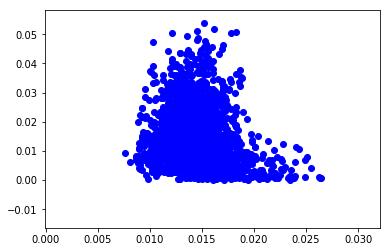

In [36]:
for i in range(AD.shape[0]):
    plt.scatter(AD_thick_median[i,:]/np.sum(AD_thick_mean[i,:]), AD_wdeg[i,:]/np.sum(AD_wdeg[i,:]),c = 'b')


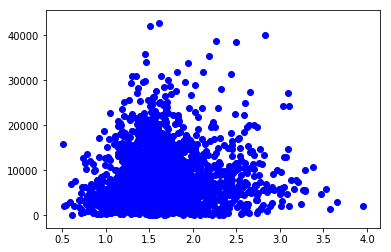

In [37]:
for i in range(AD.shape[0]):
    plt.scatter(AD_thick_quant[i,:], AD_wdeg[i,:],c = 'b')


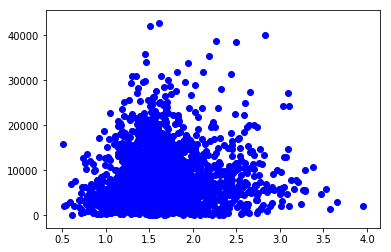

In [38]:
for i in range(AD.shape[0]):
    plt.scatter(AD_thick_quant[i,:], AD_wdeg[i,:],c = 'b')


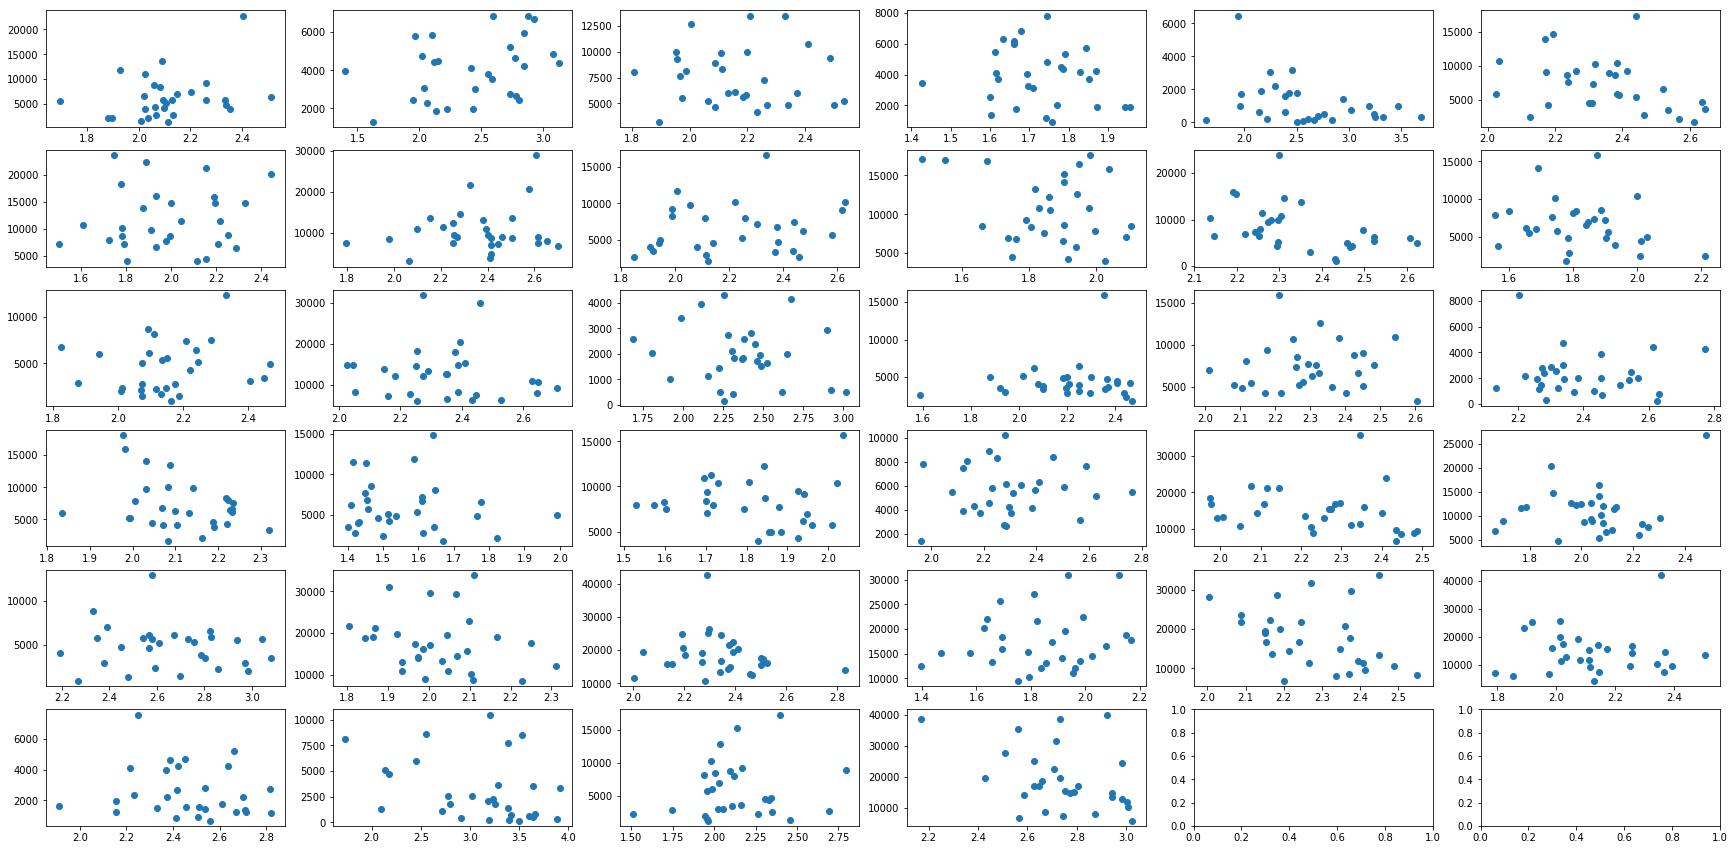

In [39]:
idx = np.arange(36).reshape(6,6)
fig, ax = plt.subplots(6,6, figsize = (30,15))
for i in range(6):
    for j in range(6):
        if i == 5:
            if j == 4:
                break
        ax[i, j].scatter(AD_thick_mean[:, idx[i,j]], AD_wdeg[:,idx[i,j]])
#         ax[i, j].set_xlim([0.01, 0.02])

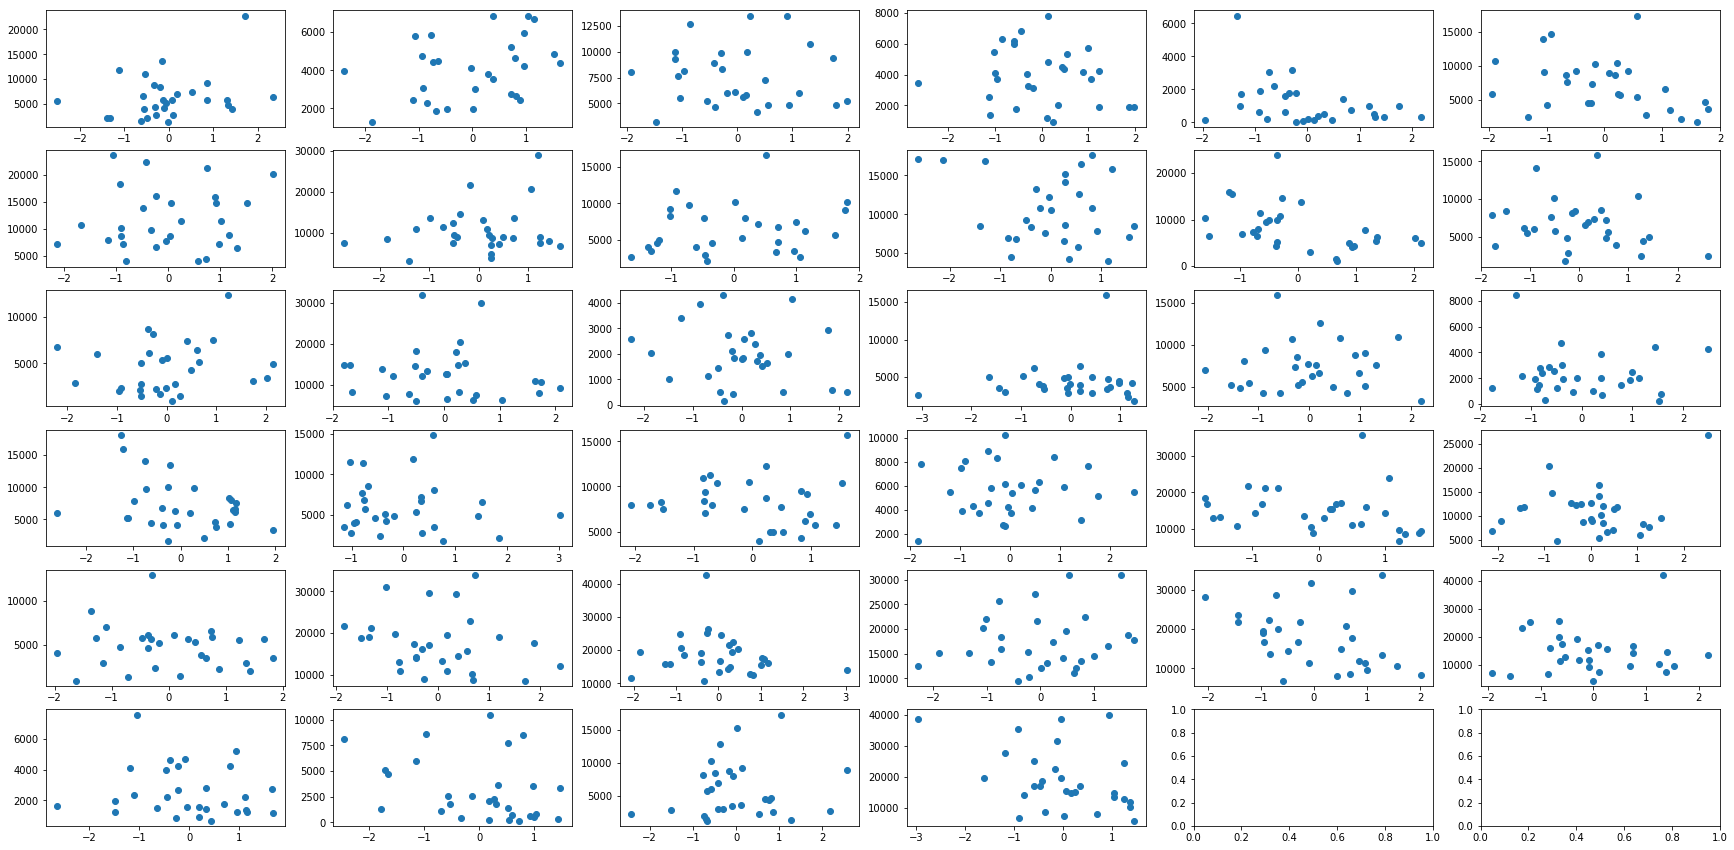

In [40]:
idx = np.arange(36).reshape(6,6)
st_AD_thick_mean = sc.fit_transform(AD_thick_mean)
fig, ax = plt.subplots(6,6, figsize = (30,15))
for i in range(6):
    for j in range(6):
        if i == 5:
            if j == 4:
                break
        ax[i, j].scatter(st_AD_thick_mean[:, idx[i,j]], AD_wdeg[:,idx[i,j]])
#         ax[i, j].set_xlim([0.01, 0.02])

In [41]:
AD_corr = np.array([spearmanr(AD_thick_mean[i,:], AD_wdeg[i,:]) for i in range(29)])
AD_corr

array([[ -1.96091155e-01,   1.09016002e-01],
       [ -4.12322139e-01,   4.76069024e-04],
       [ -4.07871130e-01,   5.55464470e-04],
       [ -2.67816926e-01,   2.72417820e-02],
       [ -3.03088140e-02,   8.06181171e-01],
       [ -2.24837050e-02,   8.55589818e-01],
       [ -7.31763179e-02,   5.53157151e-01],
       [ -2.49532389e-01,   4.01567328e-02],
       [ -1.48701652e-01,   2.26189409e-01],
       [ -3.17288239e-01,   8.37865576e-03],
       [ -1.59216704e-01,   1.94671228e-01],
       [ -5.51208154e-02,   6.55271851e-01],
       [ -1.64789861e-01,   1.79304456e-01],
       [ -3.02172004e-01,   1.22652076e-02],
       [ -4.14703974e-01,   4.37968270e-04],
       [ -1.41161202e-01,   2.50875937e-01],
       [ -7.26800779e-02,   5.55858916e-01],
       [ -2.41707066e-01,   4.70594459e-02],
       [ -3.91457037e-01,   9.63461456e-04],
       [ -6.48165821e-02,   5.99489635e-01],
       [  1.34404703e-01,   2.74504232e-01],
       [ -2.59877085e-01,   3.23393972e-02],
       [  

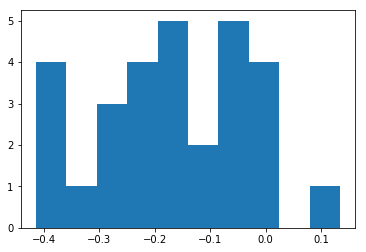

In [43]:
plt.hist(AD_corr[:,0]);

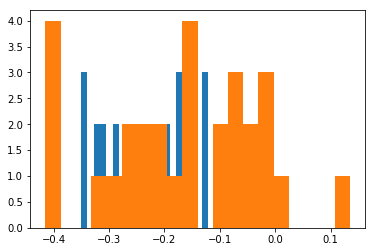

In [44]:
plt.hist(NC_corr[:,0], bins = 20)
plt.hist(AD_corr[:,0], bins = 20);

In [45]:
from scipy.stats import ttest_ind

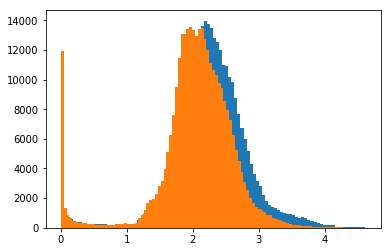

In [51]:
plt.hist(NC_thick.mean(axis = 0), bins = 100);
plt.hist(AD_thick.mean(axis = 0), bins = 100);

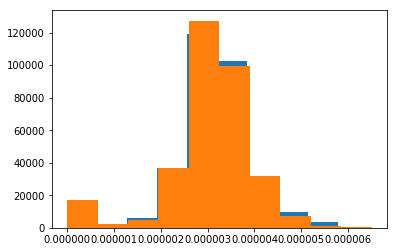

In [52]:
norm_NC_thick = np.array([NC_thick[i,:]/np.sum(NC_thick[i,:]) for i in range(Normal.shape[0])])
norm_AD_thick = np.array([AD_thick[i,:]/np.sum(AD_thick[i,:]) for i in range(AD.shape[0])])
plt.hist(norm_NC_thick.mean(axis = 0));
plt.hist(norm_AD_thick.mean(axis = 0));

In [4]:
thick_mean = np.array(thick_mean).T
thick_median = np.array(thick_median).T
thick_quant = np.array(thick_quant).T

In [5]:
wdeg = Y.sum(axis = -1)

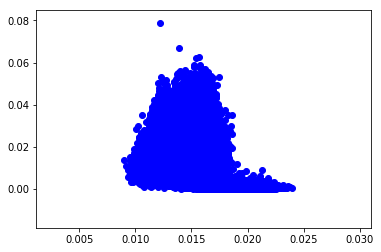

In [11]:
for i in range(789):
    plt.scatter(thick_mean[i,:]/np.sum(thick_mean[i,:]), wdeg[i,:]/np.sum(wdeg[i,:]),c = 'b')
plt.savefig('norm_thick_mean_to_norm_wdeg')

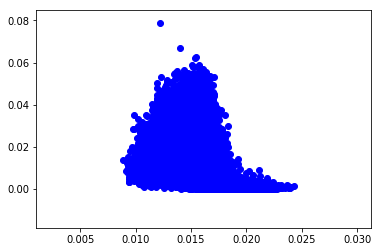

In [12]:
for i in range(789):
    plt.scatter(thick_median[i,:]/np.sum(thick_median[i,:]), wdeg[i,:]/np.sum(wdeg[i,:]),c = 'b')
plt.savefig('norm_thick_median_to_norm_wdeg')

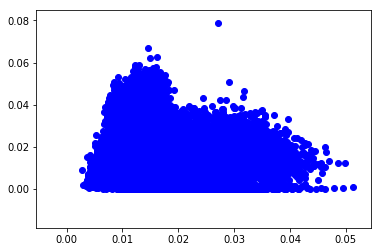

In [13]:
for i in range(789):
    plt.scatter(thick_quant[i,:]/np.sum(thick_quant[i,:]), wdeg[i,:]/np.sum(wdeg[i,:]),c = 'b')
plt.savefig('norm_thick_quantilies_to_norm_wdeg')

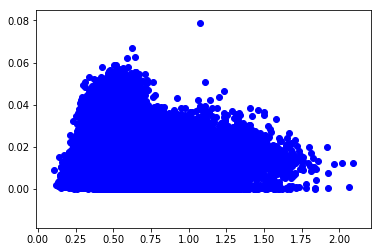

In [14]:
for i in range(789):
    plt.scatter(thick_quant[i,:], wdeg[i,:]/np.sum(wdeg[i,:]),c = 'b')
plt.savefig('thick_quantilies_to_norm_wdeg')

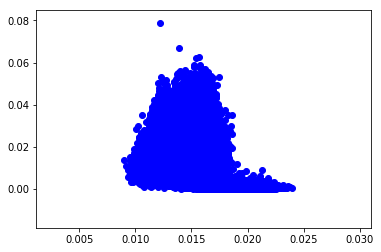

In [15]:
for i in range(789):
    plt.scatter(roi_think[i,:]/np.sum(roi_think[i,:]), wdeg[i,:]/np.sum(wdeg[i,:]),c = 'b')
plt.savefig('norm_roi_thick_to_norm_wdeg')

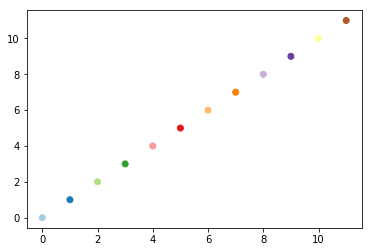

In [6]:
meta['Gender'] = meta['Gender'].astype('category')
meta['Age'] = meta['Age'].astype('category')
meta['Age'] = meta['Age'].cat.codes
meta["Gender"] = meta['Gender'].cat.codes

meta[15:20]

legend_gender = {'F':0, 'M':1}
legend_age = {'22-25':0, '26-30':1,'31-35':2, '36+':3}

color_gender = np.array(meta.Gender)
color_age = np.array(meta.Age)


%matplotlib inline

from matplotlib import cm
cmap = plt.get_cmap('Paired')
plt.scatter(range(12), range(12), c = cmap.colors)

cmap_gender = dict(zip(color_gender, [cmap.colors[1], cmap.colors[5]]))
cmap_gender

cmap_age = {0: cmap.colors[1],
            1: cmap.colors[5],
            2: cmap.colors[3], 
            3: cmap.colors[9]}

c_age = [cmap_age[i] for i in color_age]
c_gender = [cmap_gender[i] for i in color_gender]

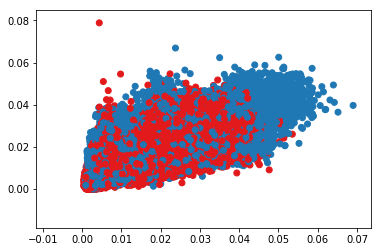

In [18]:
for i in range(789):
    plt.scatter(roi_area[i,:]/np.sum(roi_area[i,:]), wdeg[i,:]/np.sum(wdeg[i,:]),c = c_gender)
plt.savefig('norm_roi_area_to_norm_wdeg_gender')

In [19]:
np.corrcoef(roi_area[i,:]/np.sum(roi_area[i,:]), wdeg[i,:]/np.sum(wdeg[i,:]))

array([[ 1.        ,  0.71631553],
       [ 0.71631553,  1.        ]])

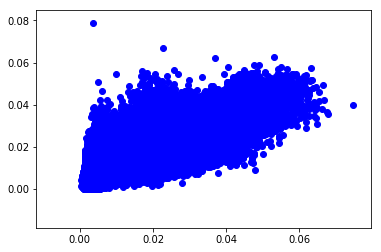

In [20]:
for i in range(789):
    plt.scatter(roi_vol[i,:]/np.sum(roi_vol[i,:]), wdeg[i,:]/np.sum(wdeg[i,:]),c = 'b')
plt.savefig('norm_roi_vol_to_norm_wdeg_gender')

In [7]:
new_thick = np.array([thick_mean[:,i]/np.sum(thick_mean, axis = -1) for i in range(68)]).T

In [8]:
wdeg_norm = np.array([wdeg[:,i]/np.sum(wdeg, axis = -1) for i in range(68)]).T

In [9]:
wdeg.shape, new_thick.shape

((789, 68), (789, 68))

(0.013, 0.017)

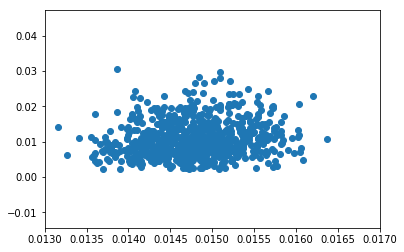

In [59]:
plt.scatter(new_thick[:,0], wdeg_norm[:,0])
plt.xlim((0.013,0.017))


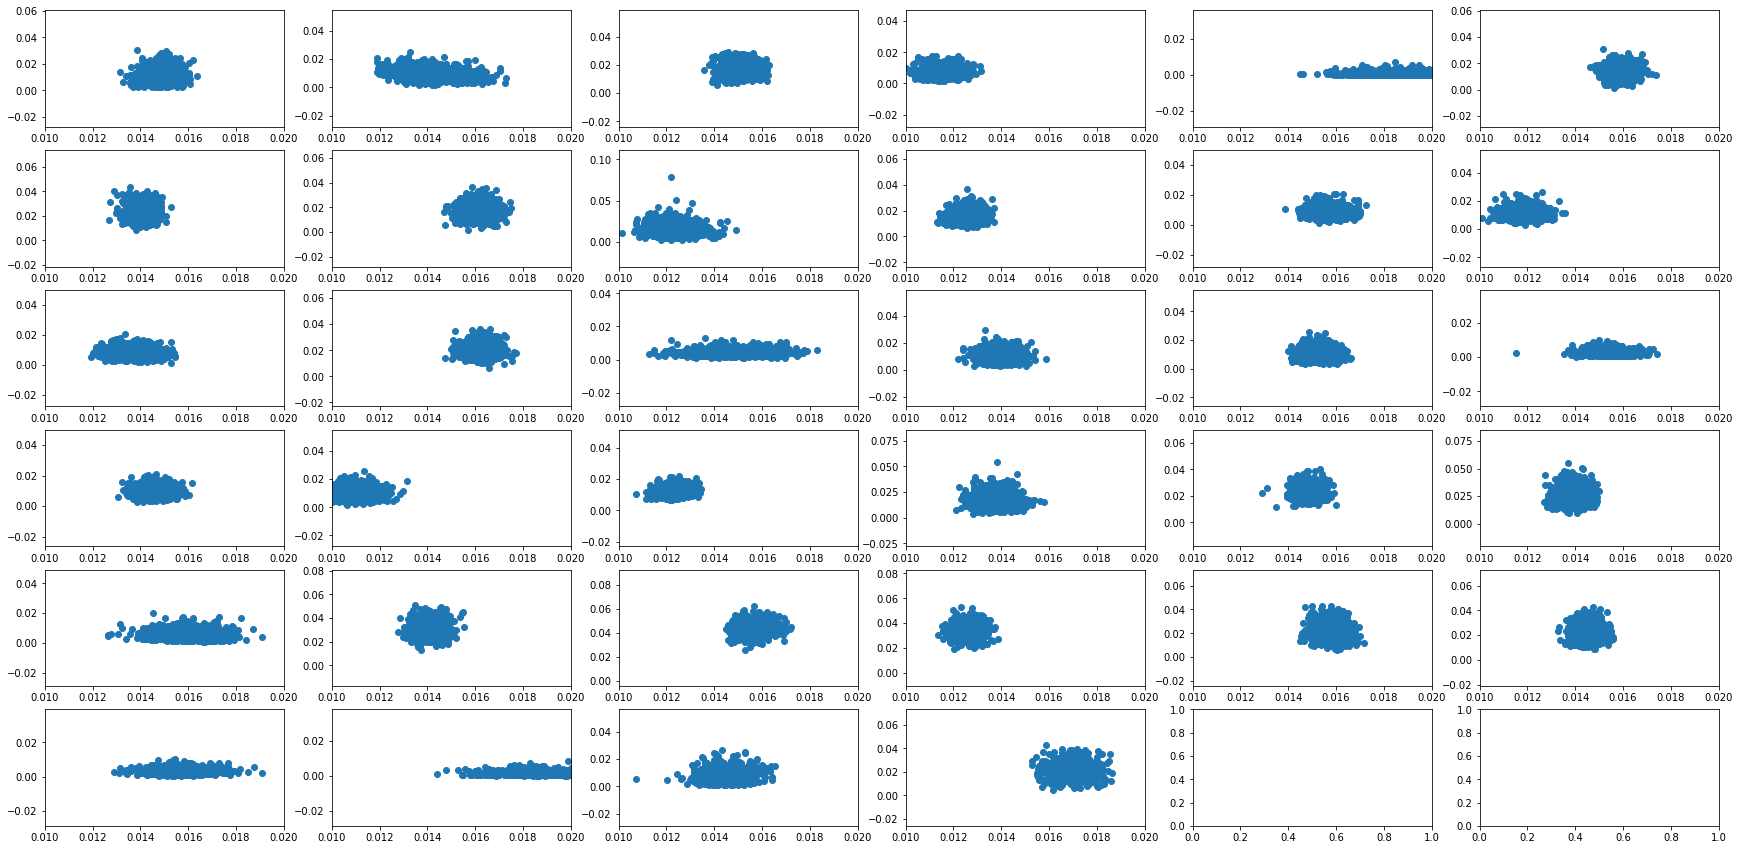

In [61]:
idx = np.arange(36).reshape(6,6)
fig, ax = plt.subplots(6,6, figsize = (30,15))
for i in range(6):
    for j in range(6):
        if i == 5:
            if j == 4:
                break
        ax[i, j].scatter(new_thick[:, idx[i,j]], wdeg_norm[:,idx[i,j]])
        ax[i, j].set_xlim([0.01, 0.02])

In [63]:
from scipy.stats import spearmanr

In [64]:
corr = np.array([spearmanr(new_thick[:,i], wdeg_norm[:,i]) for i in range(68)])

In [65]:
corr

array([[  1.58241383e-01,   7.97010842e-06],
       [ -1.56438384e-01,   1.01262218e-05],
       [  8.40675298e-02,   1.81853158e-02],
       [  8.16778070e-02,   2.17642699e-02],
       [  5.63313494e-02,   1.13867456e-01],
       [  3.33367094e-02,   3.49698144e-01],
       [  9.96913325e-03,   7.79794073e-01],
       [  3.44751579e-02,   3.33479120e-01],
       [ -3.58793854e-02,   3.14152288e-01],
       [  6.63157645e-02,   6.26242909e-02],
       [ -4.19620094e-02,   2.39065102e-01],
       [  6.09699714e-02,   8.69941069e-02],
       [ -6.12901961e-04,   9.86286158e-01],
       [  3.27138145e-02,   3.58780240e-01],
       [  2.05388915e-02,   5.64570591e-01],
       [ -3.32134152e-02,   3.51484173e-01],
       [ -5.41600936e-02,   1.28507343e-01],
       [ -4.13150257e-02,   2.46391486e-01],
       [  8.20403956e-03,   8.18027303e-01],
       [  3.74908901e-02,   2.92897203e-01],
       [  9.89902204e-02,   5.38621092e-03],
       [ -4.15176485e-02,   2.44080307e-01],
       [  

In [66]:
y = corr[:,0]
y.shape

(68,)

In [69]:
bet, clos, eig, clust

(789,)

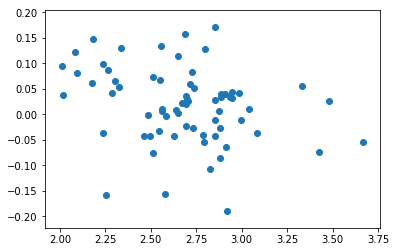

In [70]:
plt.scatter(np.mean(thick_mean, axis = 0), y)

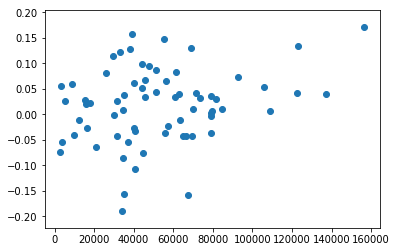

In [71]:
plt.scatter(np.mean(wdeg,axis = 0), y)

In [10]:
path_data = '/nmnt/x01-hdd/HCP/data/'


targets_name = ['clustering', 'rich_club', 'betweenness', 'closeness',  'degree_centrality', 'eigenvector']

targets_data = []
for name in targets_name:
    with open(path_data + name, 'rb') as f:
        targets_data  += [pickle.load(f)]

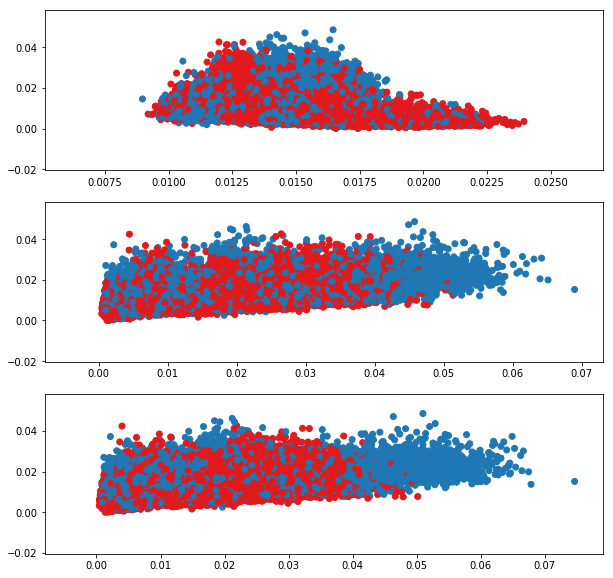

In [11]:
fig, ax = plt.subplots(3,1, figsize = (10,10))
for i in range(789):
    ax[0].scatter(thick_mean[i,:]/np.sum(thick_mean[i,:]), targets_data[0][i,:],c = c_gender)

for i in range(789):
    ax[1].scatter(roi_area[i,:]/np.sum(roi_area[i,:]), targets_data[0][i,:],c = c_gender)  
for i in range(789):
    ax[2].scatter(roi_vol[i,:]/np.sum(roi_vol[i,:]), targets_data[0][i,:],c = c_gender)

plt.savefig('norm_roi_thick_area_vol_to_norm_clustering_gender')


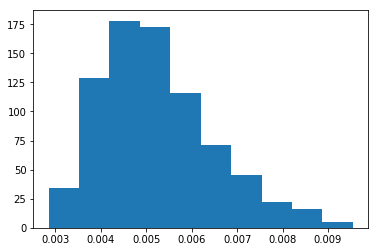

In [108]:
plt.hist(np.std(clust, axis = -1));

In [95]:
a = [spearmanr(new_thick.reshape(-1), targets_data[i].reshape(-1)) for i in [0,2,3,5]]
a

[SpearmanrResult(correlation=-0.17931149074355074, pvalue=0.0),
 SpearmanrResult(correlation=0.041282364681259981, pvalue=1.1107000938049816e-21),
 SpearmanrResult(correlation=-0.006434720188446129, pvalue=0.1361063235620841),
 SpearmanrResult(correlation=-0.25479307256248124, pvalue=0.0)]

In [96]:
new_area = np.array([roi_area[:,i]/np.sum(roi_area, axis = -1) for i in range(68)]).T
b = [spearmanr(new_area.reshape(-1), targets_data[i].reshape(-1)) for i in [0,2,3,5]]
b

[SpearmanrResult(correlation=0.64195896644089911, pvalue=0.0),
 SpearmanrResult(correlation=-0.29992628897985346, pvalue=0.0),
 SpearmanrResult(correlation=-0.14012735482786612, pvalue=2.2902529660825743e-233),
 SpearmanrResult(correlation=0.62315454163139339, pvalue=0.0)]

In [97]:
new_vol = np.array([roi_vol[:,i]/np.sum(roi_vol, axis = -1) for i in range(68)]).T
c = [spearmanr(new_vol.reshape(-1), targets_data[i].reshape(-1)) for i in [0,2,3,5]]
c

[SpearmanrResult(correlation=-0.14757065674210437, pvalue=7.2856858174512742e-259),
 SpearmanrResult(correlation=0.11836306532435387, pvalue=1.2463536837913678e-166),
 SpearmanrResult(correlation=0.081968258383390113, pvalue=1.2149436692331748e-80),
 SpearmanrResult(correlation=-0.20105933228148787, pvalue=0.0)]

In [99]:
corr_wdeg = np.array([spearmanr(roi_think[i,:], wdeg[i,:]) for i in range(789)])
all_corr = np.array([[spearmanr(roi_think[j,:], targets_data[i][j,:]) for j in range(789)] for i in [0,2,3,5]])


In [100]:
corr_wdeg.shape, all_corr.shape

((789, 2), (4, 789, 2))

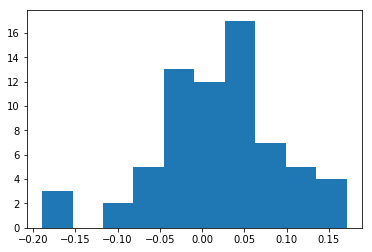

In [102]:
plt.hist(corr[:,0]);

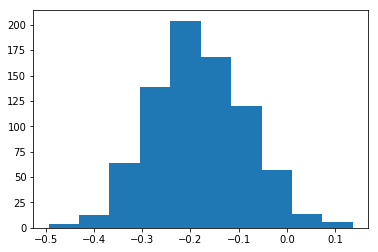

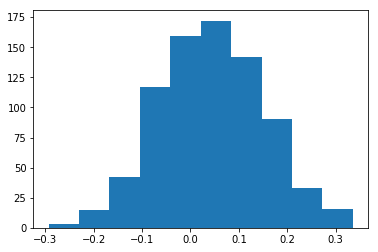

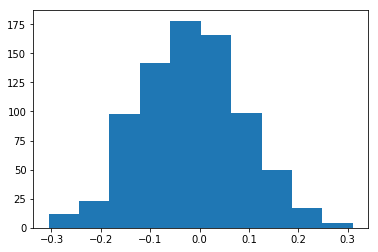

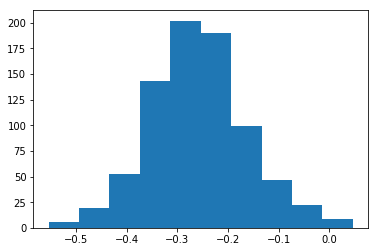

In [104]:
for i in range(4):
    plt.hist(all_corr[i][:,0])
    plt.figure();

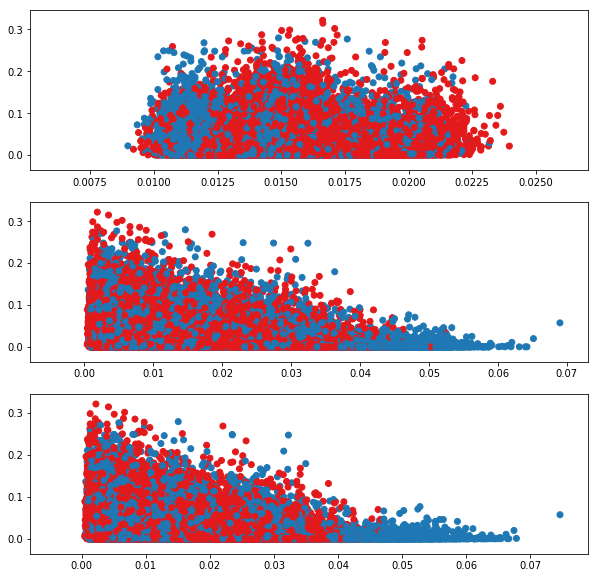

In [12]:
fig, ax = plt.subplots(3,1, figsize = (10,10))
for i in range(789):
    ax[0].scatter(thick_mean[i,:]/np.sum(thick_mean[i,:]), targets_data[2][i,:],c = c_gender)
for i in range(789):
    ax[1].scatter(roi_area[i,:]/np.sum(roi_area[i,:]), targets_data[2][i,:],c = c_gender)
for i in range(789):
    ax[2].scatter(roi_vol[i,:]/np.sum(roi_vol[i,:]), targets_data[2][i,:],c = c_gender)
plt.savefig('norm_roi_thick_area_vol_to_norm_betweenness_gender')

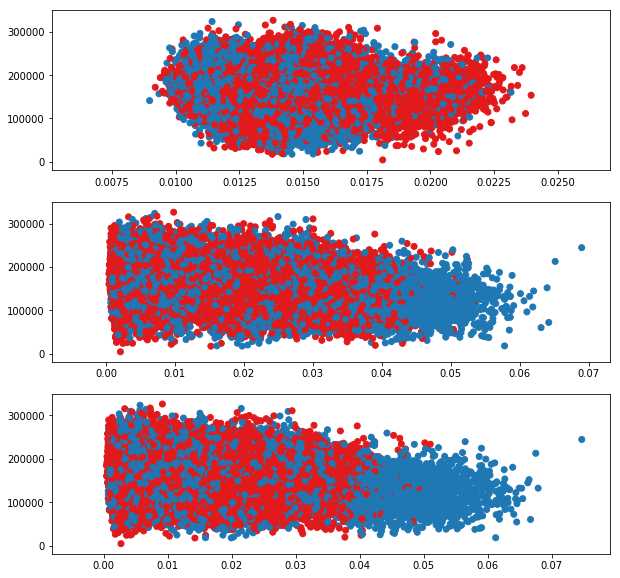

In [ ]:
fig, ax = plt.subplots(3,1, figsize = (10,10))
for i in range(789):
    ax[0].scatter(thick_mean[i,:]/np.sum(thick_mean[i,:]), targets_data[3][i,:],c = c_gender)
for i in range(789):
    ax[1].scatter(roi_area[i,:]/np.sum(roi_area[i,:]), targets_data[3][i,:],c = c_gender)
for i in range(789):
    ax[2].scatter(roi_vol[i,:]/np.sum(roi_vol[i,:]), targets_data[3][i,:],c = c_gender)
#plt.figure()
plt.savefig('norm_roi_thick_area_vol_to_norm_closeness_gender')

In [ ]:
fig, ax = plt.subplots(3,1, figsize = (10,10))
for i in range(789):
    ax[0].scatter(thick_mean[i,:]/np.sum(thick_mean[i,:]), targets_data[5][i,:],c = c_gender)
for i in range(789):
    ax[1].scatter(roi_area[i,:]/np.sum(roi_area[i,:]), targets_data[5][i,:],c = c_gender)
for i in range(789):
    ax[2].scatter(roi_vol[i,:]/np.sum(roi_vol[i,:]), targets_data[5][i,:],c = c_gender)
#plt.figure()
plt.savefig('norm_roi_thick_area_vol_to_norm_eigenval_gender')

In [33]:
def load_centers(path):
    centers = pd.DataFrame(columns = ['name', 'coordinate'])
    for name in os.listdir(path):
        
        vec = pd.read_csv(path+name)
        #print(vec.shape)
        vec.drop(vec.index[[3,38]], inplace = True)
        vec.__delitem__('Unnamed: 7')
        vec.__delitem__('region')
        vec.__delitem__('voxel_cordX')
        vec.__delitem__('voxel_cordY')
        vec.__delitem__('voxel_cordZ')
        mat = np.array(vec.as_matrix()).T
        #filename = filename[:12]
        
        single_subject = pd.DataFrame(data = [[name, mat]], 
                                      columns = ['name','coordinate'])

        centers = centers.append(single_subject)
    return centers

In [34]:
centers = load_centers(path_centers)

In [47]:
f_center = centers.coordinate.iloc[0]

In [49]:
f_center.shape

(3, 68)

In [51]:
from scipy.spatial.distance import squareform, pdist

In [52]:
dist = pdist(f_center.T)
dist.shape

(2278,)

In [81]:
mean_wconnec = squareform(Y.sum(axis = 0))
mean_bconnec = Y.copy()
mean_bconnec[Y > 0] = 1
mean_bconnec = squareform(mean_bconnec.sum(axis = 0)/len(Y))
idx_b = np.where(mean_bconnec != 0)[0]
idx_w = np.where(mean_wconnec != 0)[0]
mean_wconnec.shape, mean_bconnec.shape, idx_b.shape, idx_w.shape

((2278,), (2278,), (2051,), (2051,))

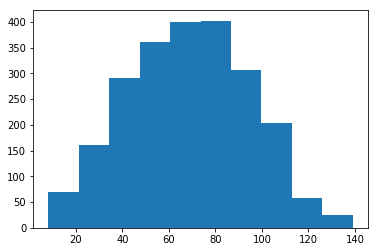

In [75]:
plt.hist(dist);

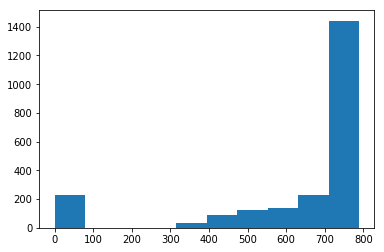

In [76]:
plt.hist(mean_bconnec);

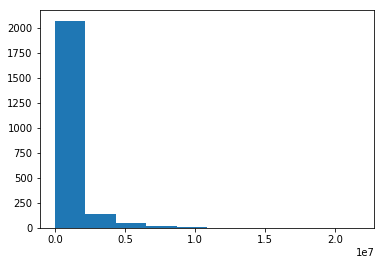

In [77]:
plt.hist(mean_wconnec);

In [86]:
min(mean_wconnec[idx_w]), max(mean_wconnec[idx_w])

(1474.0, 21713754.0)

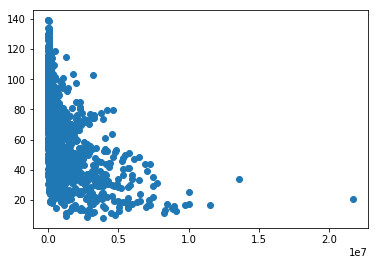

In [82]:
plt.scatter(mean_wconnec[idx_w], dist[idx_w]);

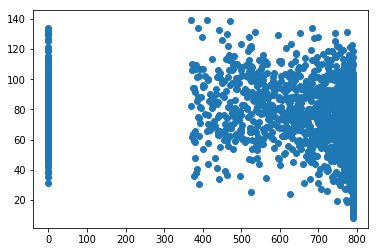

In [87]:
plt.scatter(mean_bconnec, dist);

In [89]:
a = set(subj_idx)
b = set(meta.Subject.astype(str))
c = a.difference(b)
np.where(subj_idx == c.pop())[0]

subj_idx_un = np.array(np.arange(151).tolist() + np.arange(152, 789).tolist())
subj_idx_un.shape

(788,)

In [90]:
sc = StandardScaler()

st_think = sc.fit_transform(roi_think)
mean_think = np.round(sc.mean_,2)
std_think = np.round(sc.var_,2)

st_area = sc.fit_transform(roi_area)
mean_area = np.round(sc.mean_,2)
std_area = np.round(sc.var_,2)

st_vol = sc.fit_transform(roi_vol)
mean_vol = np.round(sc.mean_,2)
std_vol = np.round(sc.var_,2)

In [91]:
wdeg = Y.sum(axis = -1)
norm_wdeg = norm_Y.sum(axis = -1)

In [92]:
max_wdeg = max(wdeg.reshape(-1))
min_wdeg = min(wdeg.reshape(-1))

max_norm_wdeg = max(norm_wdeg.reshape(-1))
min_norm_wdeg = min(norm_wdeg.reshape(-1))

max_st_think = max(st_think.reshape(-1))
min_st_think = min(st_think.reshape(-1))


max_st_area = max(st_area.reshape(-1))
min_st_area = min(st_area.reshape(-1))


max_st_vol = max(st_vol.reshape(-1))
min_st_vol = min(st_vol.reshape(-1))

# THINKNESS

In [14]:
meta[15:20]

Subject Gender    Age
27   104416      F  31-35
28   104820      F    36+
29   105014      F  26-30
30   105115      M  31-35
31   105216      M  26-30

In [15]:
meta['Gender'] = meta['Gender'].astype('category')
meta['Age'] = meta['Age'].astype('category')
meta['Age'] = meta['Age'].cat.codes
meta["Gender"] = meta['Gender'].cat.codes

meta[15:20]

legend_gender = {'F':0, 'M':1}
legend_age = {'22-25':0, '26-30':1,'31-35':2, '36+':3}

color_gender = np.array(meta.Gender)
color_age = np.array(meta.Age)


%matplotlib inline

from matplotlib import cm
cmap = plt.get_cmap('Paired')
plt.scatter(range(12), range(12), c = cmap.colors)

cmap_gender = dict(zip(color_gender, [cmap.colors[1], cmap.colors[5]]))
cmap_gender

cmap_age = {0: cmap.colors[1],
            1: cmap.colors[5],
            2: cmap.colors[3], 
            3: cmap.colors[9]}

c_age = [cmap_age[i] for i in color_age]
c_gender = [cmap_gender[i] for i in color_gender]

In [103]:
idx = np.array([i for i in range(36)]).reshape(6,6)

In [104]:
roi_think.shape

(789, 68)

In [139]:
man_idx = np.where(np.array(meta.Gender) == 1)[0]
man = roi_think[np.ix_(man_idx)]
st_man_think = sc.fit_transform(man)
man_mean_think = np.round(sc.mean_,2)
man_var_think = np.round(sc.var_,2)

woman_idx = np.where(np.array(meta.Gender) == 0)[0]
woman = roi_think[np.ix_(woman_idx)]
st_woman_think = sc.fit_transform(woman)
woman_mean_think = np.round(sc.mean_,2)
woman_var_think = np.round(sc.var_,2)

In [140]:
age0_idx = np.where(np.array(meta.Age) == 0)[0]
age0 = roi_think[np.ix_(age0_idx)]
st_age0_think = sc.fit_transform(age0)
age0_mean_think = np.round(sc.mean_,2)
age0_var_think = np.round(sc.var_,2)

age1_idx = np.where(np.array(meta.Age) == 1)[0]
age1 = roi_think[np.ix_(age1_idx)]
st_age1_think = sc.fit_transform(age1)
age1_mean_think = np.round(sc.mean_,2)
age1_var_think = np.round(sc.var_,2)

age2_idx = np.where(np.array(meta.Age) == 2)[0]
age2 = roi_think[np.ix_(age2_idx)]
st_age2_think = sc.fit_transform(age2)
age2_mean_think = np.round(sc.mean_,2)
age2_var_think = np.round(sc.var_,2)

age3_idx = np.where(np.array(meta.Age) == 3)[0]
age3 = roi_think[np.ix_(age3_idx)]
st_age3_think = sc.fit_transform(age3)
age3_mean_think = np.round(sc.mean_,2)
age3_var_think = np.round(sc.var_,2)

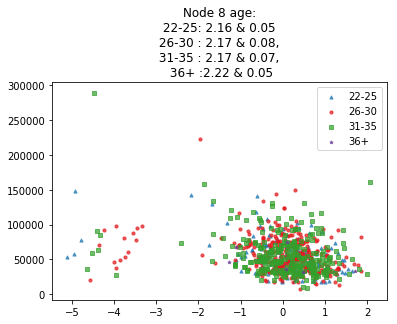

In [153]:
i = 1
j = 2
plt.scatter(st_age0_think[:, idx[i,j]], wdeg[age0_idx, idx[i,j]],
                         marker = '^', c = cmap_age[legend_age['22-25']], 
                        s = 10, alpha = 0.7, label = '22-25')

plt.scatter(st_age1_think[:, idx[i,j]], wdeg[age1_idx, idx[i,j]],
                marker = 'o', c = cmap_age[legend_age['26-30']],
                s = 10, alpha = 0.7, label = '26-30')

plt.scatter(st_age2_think[:, idx[i,j]], wdeg[age2_idx, idx[i,j]],
                marker = 's', c = cmap_age[legend_age['31-35']],
                s = 10, alpha = 0.7, label = '31-35')

plt.scatter(st_age3_think[:, idx[i,j]], wdeg[age3_idx, idx[i,j]],
                marker = '*', c = cmap_age[legend_age['36+']],
                s = 10, alpha = 0.7, label = '36+')
plt.legend()
plt.title("Node {0:.0f} age:\n 22-25: {1:.2f} & {2:.2f} \n 26-30 \
: {3:.2f} & {4:.2f}, \n 31-35 : {5:.2f} & {6:.2f}, \n 36+ :{7:.2f} & {8:.2f}".format(idx[i,j], 
                                age0_mean_think[idx[i,j]], age0_var_think[idx[i,j]],
                                age1_mean_think[idx[i,j]], age1_var_think[idx[i,j]],
                                age2_mean_think[idx[i,j]], age2_var_think[idx[i,j]],
                                age3_mean_think[idx[i,j]], age3_var_think[idx[i,j]]))
plt.savefig('ages_roi_to_thick_8')

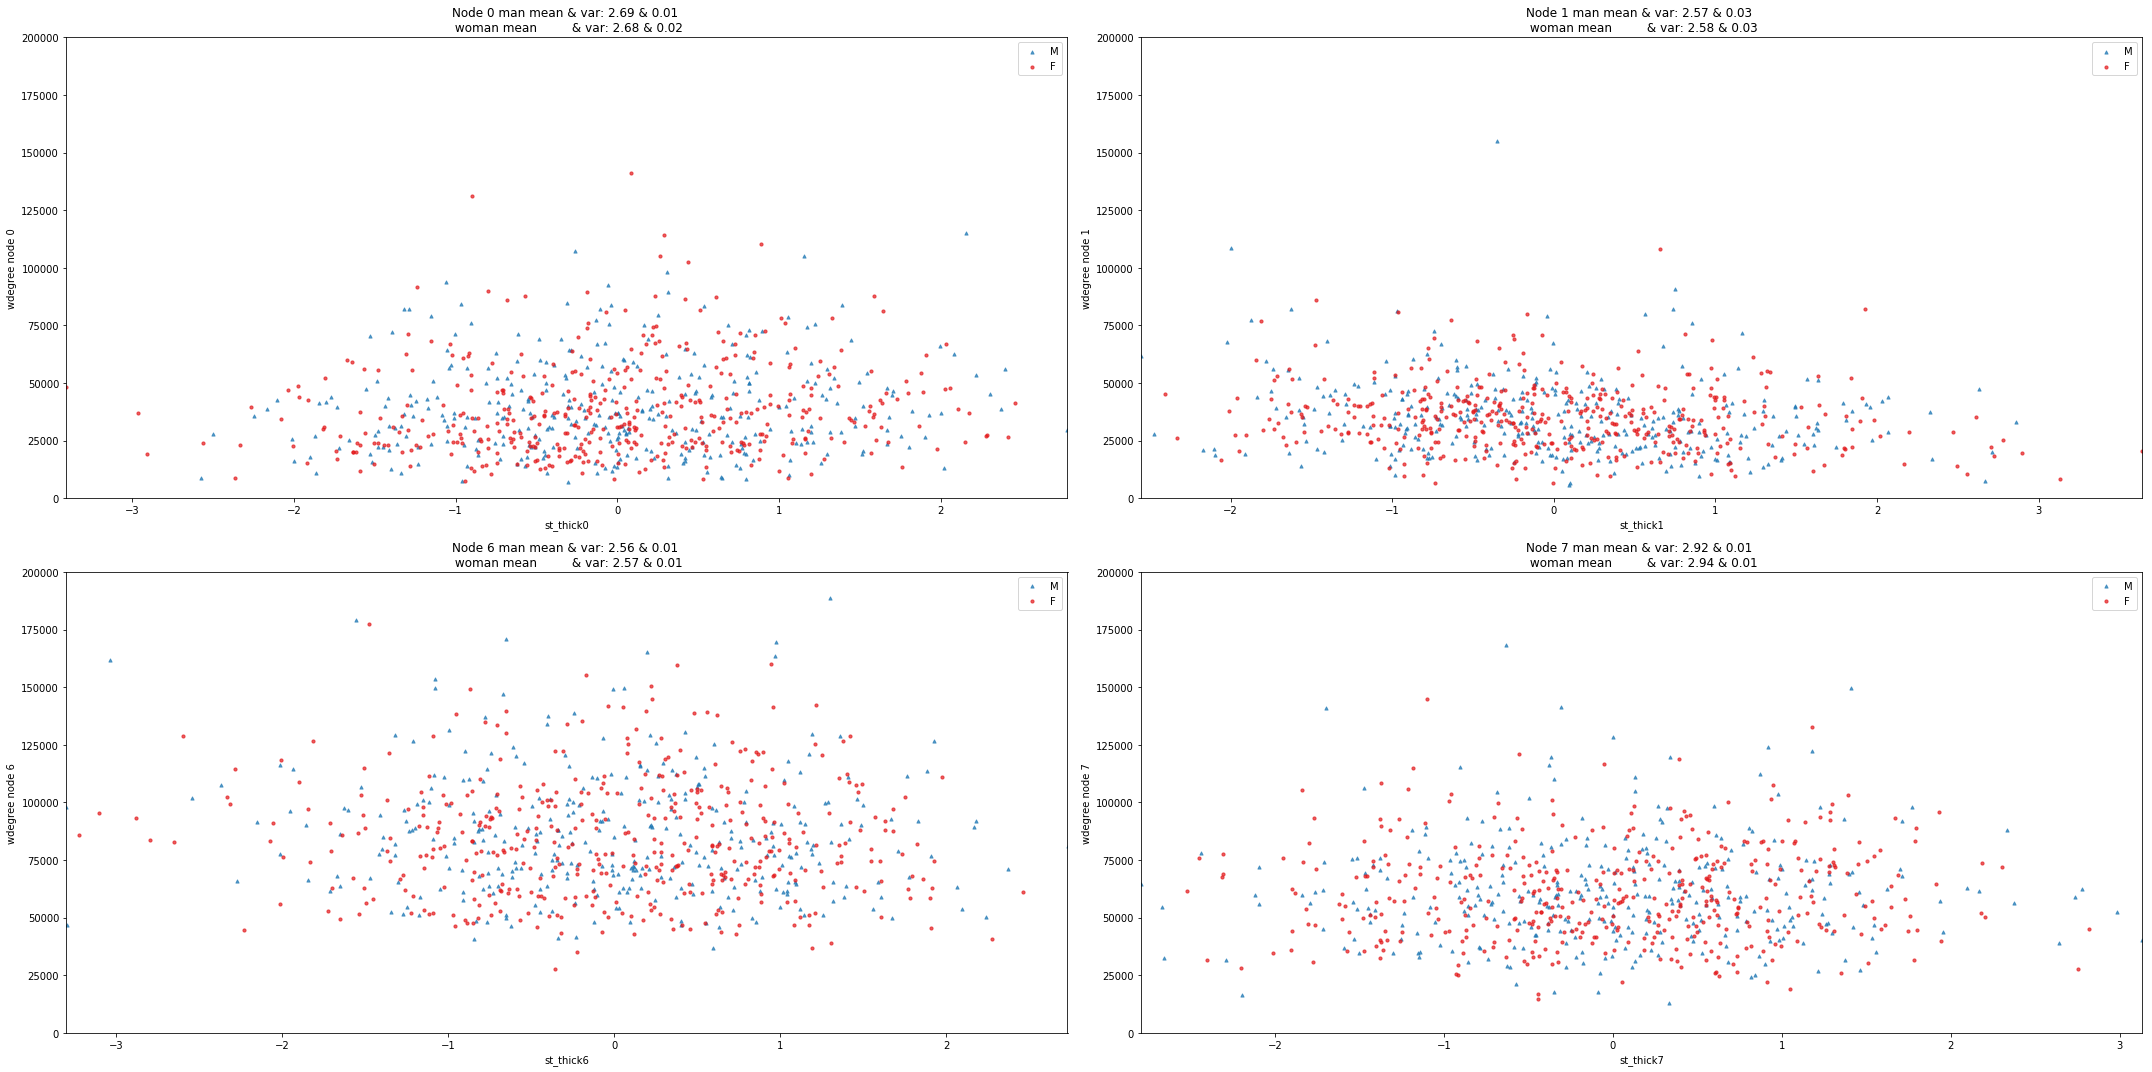

In [141]:
fig, ax = plt.subplots(2,2, figsize = (30,15))
for i in range(0,2):
    for j in range(0,2):
        if i == 5:
            if j == 4:
                break
        ax[i, j].scatter(st_man_think[:, idx[i,j]], wdeg[man_idx, idx[i,j]],
                         marker = '^', c = cmap_gender[legend_gender['M']], 
                        s = 10, alpha = 0.7, label = 'M')
        
        ax[i, j].scatter(st_woman_think[:, idx[i,j]], wdeg[woman_idx, idx[i,j]],
                        marker = 'o', c = cmap_gender[legend_gender['F']],
                        s = 10, alpha = 0.7, label = 'F')
        ax[i, j].legend()
        ax[i, j].set_title("Node {0:.0f} man mean & var: {1:.2f} & {2:.2f} \n woman mean \
        & var: {3:.2f} & {4:.2f}".format(idx[i,j], man_mean_think[idx[i,j]],
                                         man_var_think[idx[i,j]],
                                         woman_mean_think[idx[i,j]], woman_var_think[idx[i,j]]))
        
        ax[i, j].set_xlabel('st_thick' + str(idx[i,j]))
        ax[i, j].set_ylabel('wdegree node ' + str(idx[i,j]))
        ax[i, j].set_xlim([min(min(st_man_think[:,idx[i,j]]), min(st_woman_think[:,idx[i,j]])),
                           max(max(st_man_think[:,idx[i,j]]), max(st_woman_think[:,idx[i,j]]))])
        ax[i, j].set_ylim([min_wdeg, 200000])
plt.tight_layout()
plt.savefig( 'woman_man_thinkness_to_wdeg', dpi = 200)

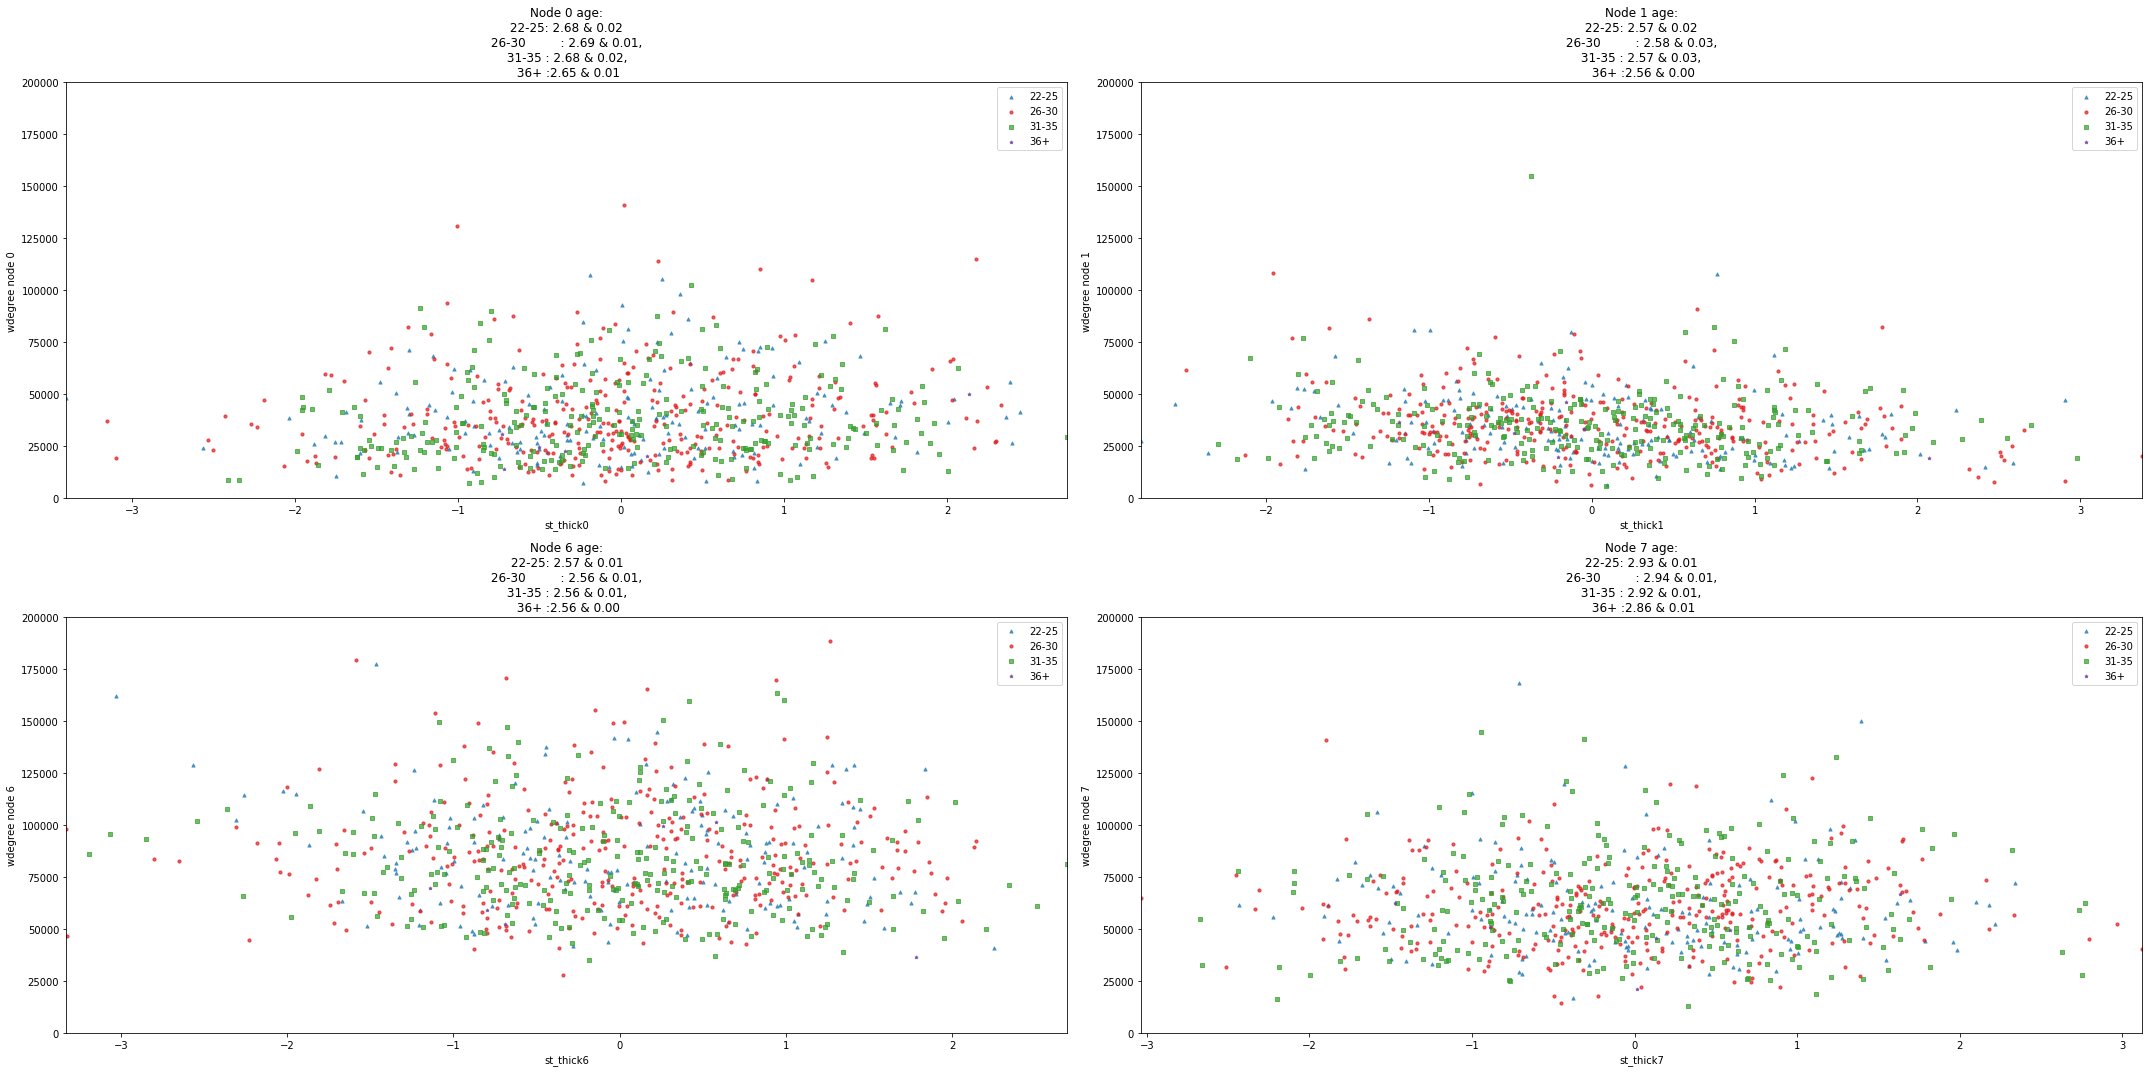

In [211]:
fig, ax = plt.subplots(2,2, figsize = (30,15))
for i in range(0,2):
    for j in range(0,2):
        if i == 5:
            if j == 4:
                break
        ax[i, j].scatter(st_age0_think[:, idx[i,j]], wdeg[age0_idx, idx[i,j]],
                         marker = '^', c = cmap_age[legend_age['22-25']], 
                        s = 10, alpha = 0.7, label = '22-25')
        
        ax[i, j].scatter(st_age1_think[:, idx[i,j]], wdeg[age1_idx, idx[i,j]],
                        marker = 'o', c = cmap_age[legend_age['26-30']],
                        s = 10, alpha = 0.7, label = '26-30')
        
        ax[i, j].scatter(st_age2_think[:, idx[i,j]], wdeg[age2_idx, idx[i,j]],
                        marker = 's', c = cmap_age[legend_age['31-35']],
                        s = 10, alpha = 0.7, label = '31-35')
        
        ax[i, j].scatter(st_age3_think[:, idx[i,j]], wdeg[age3_idx, idx[i,j]],
                        marker = '*', c = cmap_age[legend_age['36+']],
                        s = 10, alpha = 0.7, label = '36+')
        ax[i, j].legend()
        
        ax[i, j].set_title("Node {0:.0f} age:\n 22-25: {1:.2f} & {2:.2f} \n 26-30 \
        : {3:.2f} & {4:.2f}, \n 31-35 : {5:.2f} & {6:.2f}, \n 36+ :{7:.2f} & {8:.2f}".format(idx[i,j], 
                                        age0_mean_think[idx[i,j]], age0_var_think[idx[i,j]],
                                        age1_mean_think[idx[i,j]], age1_var_think[idx[i,j]],
                                        age2_mean_think[idx[i,j]], age2_var_think[idx[i,j]],
                                        age3_mean_think[idx[i,j]], age3_var_think[idx[i,j]]))
        
        ax[i, j].set_xlabel('st_thick' + str(idx[i,j]))
        ax[i, j].set_ylabel('wdegree node ' + str(idx[i,j]))
        min_age = min(np.concatenate([st_age0_think[:,idx[i,j]], st_age1_think[:,idx[i,j]],
                                     st_age2_think[:,idx[i,j]], st_age3_think[:,idx[i,j]]]).reshape(-1))
        max_age = max(np.concatenate([st_age0_think[:,idx[i,j]], st_age1_think[:,idx[i,j]],
                                     st_age2_think[:,idx[i,j]], st_age3_think[:,idx[i,j]]]).reshape(-1))
        ax[i, j].set_xlim([min_age,max_age])
        ax[i, j].set_ylim([min_wdeg, 200000])
plt.tight_layout()
plt.savefig( 'ages_thinkness_to_wdeg', dpi = 200)

In [211]:
a = set(man_idx)
b = set(age0_idx)
c0 = a.intersection(b)
c0 = np.array(list(c0))

age0_man = roi_think[c0]
st_age0_man = sc.fit_transform(age0_man)
age0_man_mean = sc.mean_
age0_man_var = sc.var_

b = set(age2_idx)
c2 = np.array(list(a.intersection(b)))
age2_man = roi_think[c2]
st_age2_man = sc.fit_transform(age2_man)
age2_man_mean = sc.mean_
age2_man_var = sc.var_



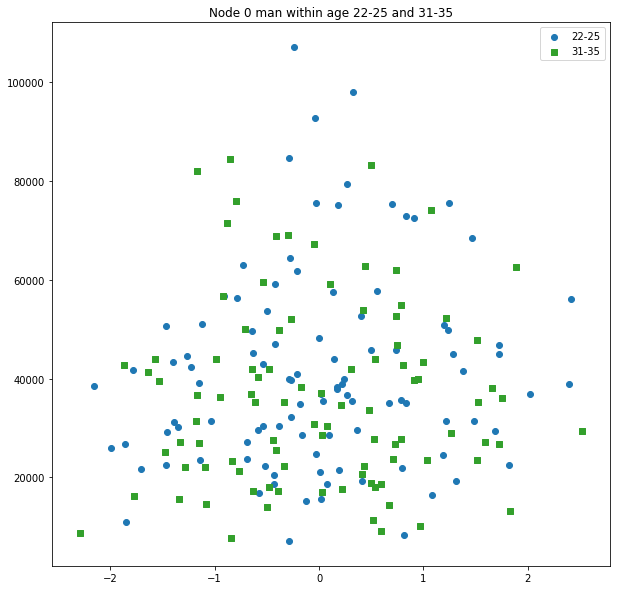

In [213]:
i = 0
j = 0
plt.figure(figsize = (10,10))
plt.scatter(st_age0_man[:, idx[i,j]], wdeg[c0, idx[i,j]],
                         marker = 'o', c = cmap_age[legend_age['22-25']], 
                        label = '22-25')

# plt.scatter(st_age1_think[:, idx[i,j]], wdeg[age1_idx, idx[i,j]],
#                 marker = 'o', c = cmap_age[legend_age['26-30']],
#                 s = 10, alpha = 0.7, label = '26-30')

plt.scatter(st_age2_man[:, idx[i,j]], wdeg[c2, idx[i,j]],
                marker = 's', c = cmap_age[legend_age['31-35']],
                 label = '31-35')

# plt.scatter(st_age3_think[:, idx[i,j]], wdeg[age3_idx, idx[i,j]],
#                 marker = 's', c = cmap_age[legend_age['36+']],
#                 s = 50, alpha = 0.7, label = '36+')
plt.title('Node '+ str(idx[i,j])  + ' man within age 22-25 and 31-35')
plt.legend()
plt.savefig('man_to_ages_thick')

In [214]:
a = set(woman_idx)
b = set(age0_idx)
c0 = a.intersection(b)
c0 = np.array(list(c0))

age0_woman = roi_think[c0]
st_age0_woman = sc.fit_transform(age0_woman)
age0_woman_mean = sc.mean_
age0_woman_var = sc.var_

b = set(age2_idx)
c2 = np.array(list(a.intersection(b)))
age2_woman = roi_think[c2]
st_age2_woman = sc.fit_transform(age2_woman)
age2_woman_mean = sc.mean_
age2_woman_var = sc.var_



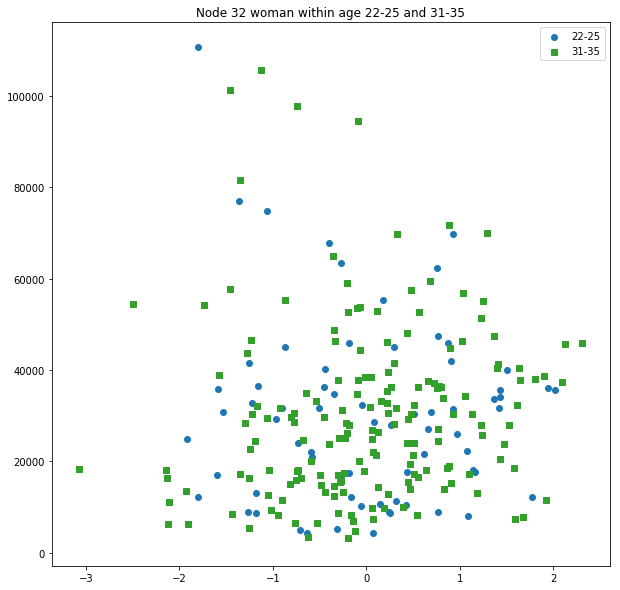

In [215]:
i = 5
j = 2
plt.figure(figsize = (10,10))
plt.scatter(st_age0_woman[:, idx[i,j]], wdeg[c0, idx[i,j]],
                         marker = 'o', c = cmap_age[legend_age['22-25']], 
                         label = '22-25')

# plt.scatter(st_age1_think[:, idx[i,j]], wdeg[age1_idx, idx[i,j]],
#                 marker = 'o', c = cmap_age[legend_age['26-30']],
#                 s = 10, alpha = 0.7, label = '26-30')

plt.scatter(st_age2_woman[:, idx[i,j]], wdeg[c2, idx[i,j]],
                marker = 's', c = cmap_age[legend_age['31-35']],
                 label = '31-35')

# plt.scatter(st_age3_think[:, idx[i,j]], wdeg[age3_idx, idx[i,j]],
#                 marker = 's', c = cmap_age[legend_age['36+']],
#                 s = 50, alpha = 0.7, label = '36+')
plt.title('Node '+ str(idx[i,j])  + ' woman within age 22-25 and 31-35')
plt.legend()
plt.savefig('woman_to_age_thick', )

In [176]:
def topk_degrees(dataset, k=10, subj_num=None):
    '''    
     input
     
     dataset - array n x 68 x 68
     k - number of heaviest nodes to consider (from each matrix)
     subj_num - number of subjects to choose final indices
     
     output
     
     node ids with nodes which have highest degree among all subjects (0..68)
     frequencies of these nodes (0..n)
    '''
     
    if subj_num is None:
        subj_num = int(dataset.shape[0]/2)
    
    degrees = dataset.sum(axis=1) # array n x 68
    topk_dgr_ind = []
    
    for row in degrees:
        order = np.argsort(row) 
        topk_dgr_ind.append(order[:k]) # take top k heaviest nodes
        
    topk_dgr_ind = np.hstack(topk_dgr_ind)
    nodes_id, freq = np.unique(topk_dgr_ind, return_counts=True) # compute number of times i'th node
    # is heavy among all subjects, if this number is bigger than subj_num we will choose it later
    
    return nodes_id[freq > subj_num], freq[freq > subj_num]

def botk_degrees(dataset, k=10, subj_num=None):
    '''    
     input
     
     dataset - array n x 68 x 68
     k - number of heaviest nodes to consider (from each matrix)
     subj_num - number of subjects to choose final indices
     
     output
     
     node ids with nodes which have highest degree among all subjects (0..68)
     frequencies of these nodes (0..n)
    '''
     
    if subj_num is None:
        subj_num = int(dataset.shape[0]/2)
    
    degrees = dataset.sum(axis=1) # array n x 68
    topk_dgr_ind = []
    
    for row in degrees:
        order = np.argsort(row) 
        topk_dgr_ind.append(order[-k:]) # take top k heaviest nodes
        
    topk_dgr_ind = np.hstack(topk_dgr_ind)
    nodes_id, freq = np.unique(topk_dgr_ind, return_counts=True) # compute number of times i'th node
    # is heavy among all subjects, if this number is bigger than subj_num we will choose it later
    
    return nodes_id[freq > subj_num], freq[freq > subj_num]

In [177]:
def topk_thick(degrees, k=10, subj_num=None):
    '''    
     input
     
     dataset - array n x 68 x 68
     k - number of heaviest nodes to consider (from each matrix)
     subj_num - number of subjects to choose final indices
     
     output
     
     node ids with nodes which have highest degree among all subjects (0..68)
     frequencies of these nodes (0..n)
    '''
     
    if subj_num is None:
        subj_num = int(degrees.shape[0]/2)
    
     # array n x 68
    topk_dgr_ind = []
    
    for row in degrees:
        order = np.argsort(row) 
        topk_dgr_ind.append(order[:k]) # take top k heaviest nodes
        
    topk_dgr_ind = np.hstack(topk_dgr_ind)
    nodes_id, freq = np.unique(topk_dgr_ind, return_counts=True) # compute number of times i'th node
    # is heavy among all subjects, if this number is bigger than subj_num we will choose it later
    
    return nodes_id[freq > subj_num], freq[freq > subj_num]

def botk_thick(degrees, k=10, subj_num=None):
    '''    
     input
     
     dataset - array n x 68 x 68
     k - number of heaviest nodes to consider (from each matrix)
     subj_num - number of subjects to choose final indices
     
     output
     
     node ids with nodes which have highest degree among all subjects (0..68)
     frequencies of these nodes (0..n)
    '''
     
    if subj_num is None:
        subj_num = int(degrees.shape[0]/2)
    
    #degrees = dataset.sum(axis=1) # array n x 68
    topk_dgr_ind = []
    
    for row in degrees:
        order = np.argsort(row) 
        topk_dgr_ind.append(order[-k:]) # take top k heaviest nodes
        
    topk_dgr_ind = np.hstack(topk_dgr_ind)
    nodes_id, freq = np.unique(topk_dgr_ind, return_counts=True) # compute number of times i'th node
    # is heavy among all subjects, if this number is bigger than subj_num we will choose it later
    
    return nodes_id[freq > subj_num], freq[freq > subj_num]

In [181]:
top_nodes, top_freq_nodes = topk_degrees(Y, k = 10)
bot_nodes, bot_freq_nodes = botk_degrees(Y, k = 10)
top_nodes, bot_nodes

(array([ 4, 14, 17, 30, 31, 38, 51, 65, 66]),
 array([23, 25, 26, 27, 57, 60, 61]))

In [180]:
top_nodes, top_freq_nodes = topk_degrees(Y, k = 2)
bot_nodes, bot_freq_nodes = botk_degrees(Y, k = 2)
top_nodes, bot_nodes

(array([ 4, 38]), array([26, 60]))

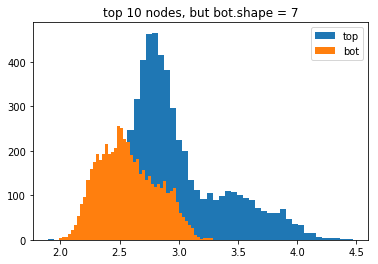

In [184]:
top_thick = roi_think[:, top_nodes[:4].tolist() + top_nodes[6:].tolist()]
bot_thick = roi_think[:, bot_nodes]
plt.hist(top_thick.reshape(-1), bins = 50, label = 'top')
plt.hist(bot_thick.reshape(-1), bins = 50, label = 'bot');
plt.legend();
# plt.title('38 - top mean & std: {0:.3f} & {1:.3f} \n 60 - bot mean & std: {2:.3f} & {3:.3f}'.format(top_thick.mean(),
#                                                                                           top_thick.std(),
#                                                                                           bot_thick.mean() , 
#                                                                                           bot_thick.std()))
plt.title('top 10 nodes, but bot.shape = 7')
plt.savefig('7_top_bot_hist', dpi = 200)

In [222]:
top_thick.mean(), top_thick.std(), bot_thick.mean() , bot_thick.std()

(3.4267182, 0.22505398, 2.8886688, 0.12647474)

In [223]:
from scipy.stats import ttest_ind
t, p = ttest_ind(top_thick, bot_thick)
print(p)

0.0


In [178]:
top_vol, freq_top_vol = topk_thick(roi_vol, k = 10)
bot_vol, freq_bot_vol = botk_thick(roi_vol, k = 10)
top_vol, bot_vol

(array([ 8, 20, 21, 33, 42, 54, 66, 67]),
 array([ 7, 13, 25, 30, 31, 41, 47, 51, 59, 64, 65]))

In [227]:
top_vol, freq_top_vol = topk_thick(roi_vol, k = 2)
bot_vol, freq_bot_vol = botk_thick(roi_vol, k = 2)
top_vol, bot_vol

(array([ 8, 42]), array([51]))

In [228]:
freq_top_vol, freq_bot_vol

(array([582, 483]), array([469]))

In [229]:
deg_top_vol = Y.sum(axis = -1)[:, [42]]
deg_bot_vol = Y.sum(axis = -1)[:, [51]]

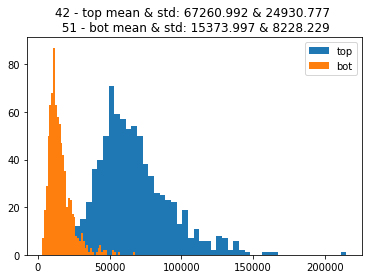

In [231]:
plt.hist(deg_top_vol.reshape(-1), bins=50, label = 'top')
plt.hist(deg_bot_vol.reshape(-1), bins = 50, label = 'bot')
plt.title('42 - top mean & std: {0:.3f} & {1:.3f} \n 51 - bot mean & std: {2:.3f} & {3:.3f}'.format(deg_top_vol.mean(),
                                                                                          deg_top_vol.std(),
                                                                                          deg_bot_vol.mean() , 
                                                                                          deg_bot_vol.std()))
plt.legend();
plt.savefig('1_vol_top_bot_hist')

In [232]:
ttest_ind(deg_top_vol, deg_bot_vol)

Ttest_indResult(statistic=array([ 55.47969055], dtype=float32), pvalue=array([ 0.]))

In [164]:
top_thickness, top_thick_freq = topk_thick(roi_think, k = 2)
bot_thickness, bot_thick_freq = botk_thick(roi_think, k = 2)
top_thickness, bot_thickness

(array([19, 53]), array([31, 65]))

In [165]:
top_thickness, top_thick_freq = topk_thick(roi_vol, k = 2)
bot_thickness, bot_thick_freq = botk_thick(roi_vol, k = 2)

In [166]:
top_thickness, bot_thickness, 

(array([ 8, 42]), array([51]))

In [163]:
new_Y = Y[subj_idx_un,:,:]

In [123]:
new_Y.shape
new_roi = roi_think[subj_idx_un, :]

In [134]:
top_nodes, top_freq = topk_degrees(new_Y, k = 10)
bot_nodes, bot_freq = botk_degrees(new_Y, k = 10)

In [135]:
top_nodes, bot_nodes

(array([ 4, 14, 17, 30, 31, 38, 51, 65, 66]),
 array([23, 25, 26, 27, 57, 60, 61]))

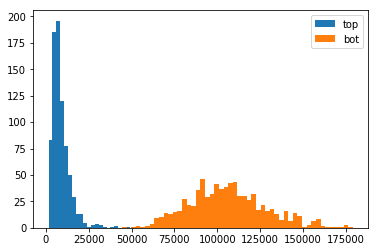

In [173]:
# объемы ! топ и бот 
top_thick = Y.sum(axis = -1)[:, top_nodes[-1]]
bot_thick = Y.sum(axis = -1)[:, bot_nodes[-1]]
plt.hist(top_thick.reshape(-1), bins = 50, label = 'top')
plt.hist(bot_thick.reshape(-1), bins = 50, label = 'bot');
plt.legend();

In [167]:
top_thick = new_roi[:, top_nodes[-1]]
bot_thick = new_roi[:, bot_nodes[-1]]

In [168]:
top_deg = new_Y.sum(axis = -1)[:, top_thickness[:3]]
bot_deg = new_Y.sum(axis = -1)[:, bot_thickness[:3]]

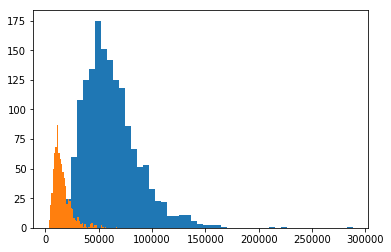

In [169]:
plt.hist(top_deg.reshape(-1), bins = 50)
plt.hist(bot_deg.reshape(-1), bins = 50);

In [137]:
top_thick.mean(), top_thick.std(), bot_thick.mean(), bot_thick.std()

(2.9128771, 0.3191154, 2.5540137, 0.22972384)

In [ ]:
import scipy.stats import 

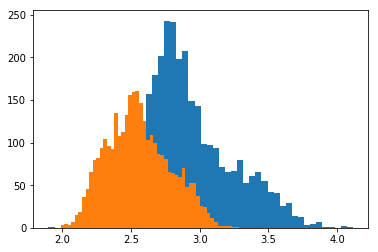

In [139]:
plt.hist(top_thick.reshape(-1), bins = 50)
plt.hist(bot_thick.reshape(-1), bins = 50);

ValueError: Invalid RGBA argument: 2

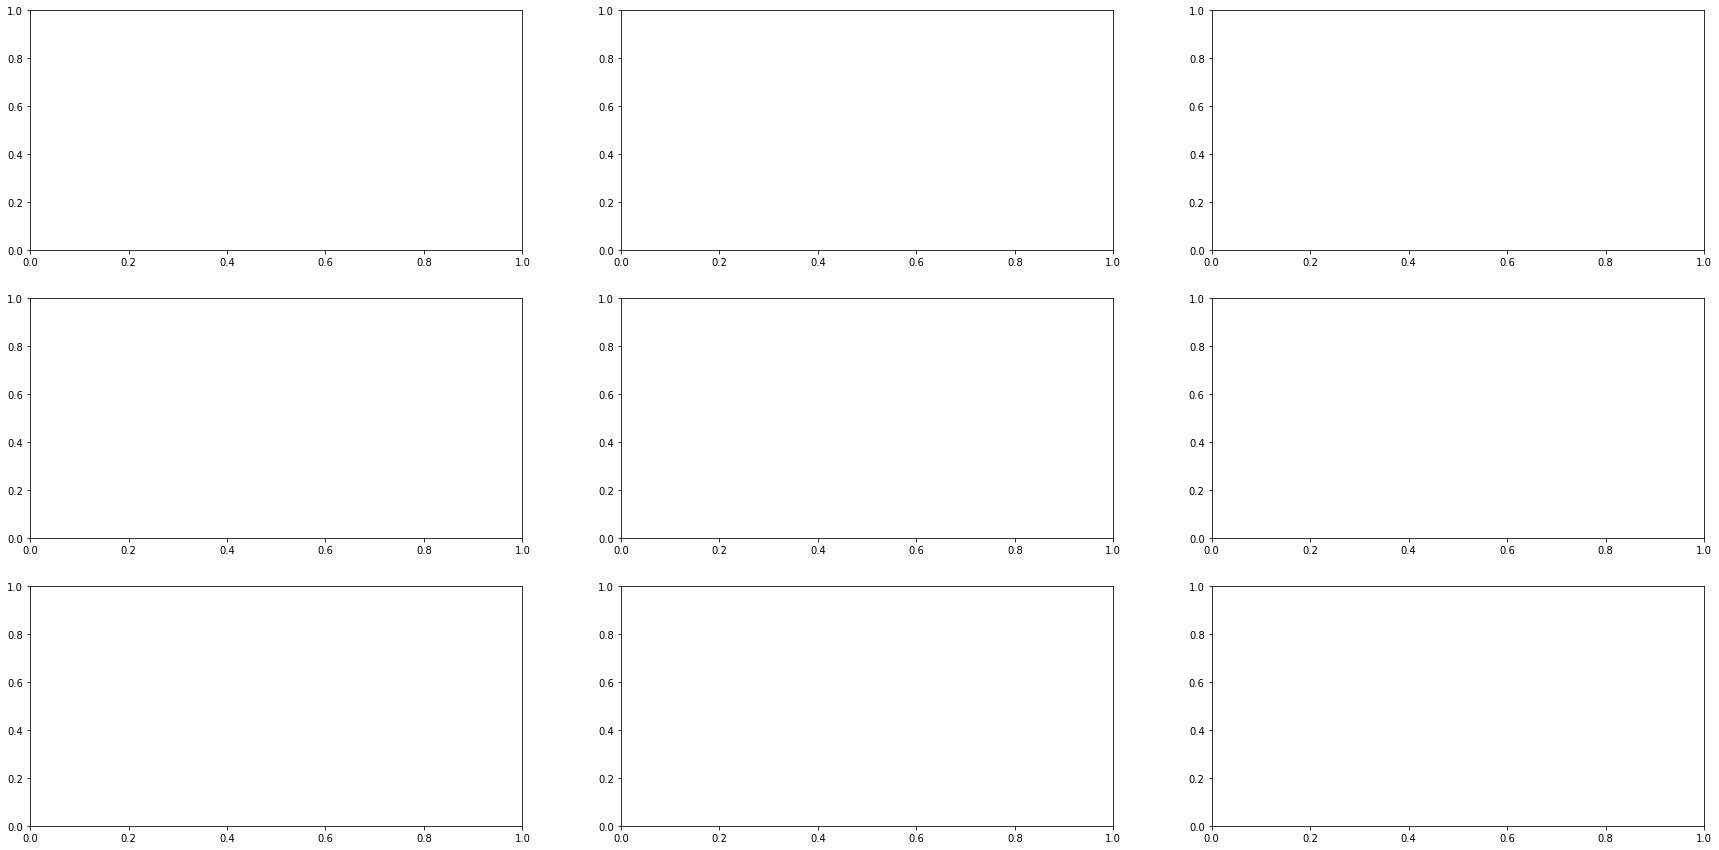

In [188]:
fig, ax = plt.subplots(3,3, figsize = (30,15))
for i in range(2,5):
    for j in range(2,5):
        if i == 5:
            if j == 4:
                break
        ax[i, j].scatter(st_think[np.ix_(subj_idx_un), idx[i,j]], wdeg[np.ix_(subj_idx_un),idx[i,j]], c= c )
        ax[i, j].set_title('Node ' + str(idx[i,j]) + ', with mean = ' + str(mean_think[idx[i,j]]) + 'and std = ' + str(std_think[idx[i,j]]))
        ax[i, j].set_xlabel('st thick for ' + str(idx[i,j]) + 'node')
        ax[i, j].set_ylabel('wdegree node ' + str(idx[i,j]))
        ax[i, j].set_xlim([min_st_think, max_st_think])
        ax[i, j].set_ylim([min_wdeg, max_wdeg])
plt.tight_layout()
plt.savefig( 'thinkness_to_wdeg', dpi = 200)

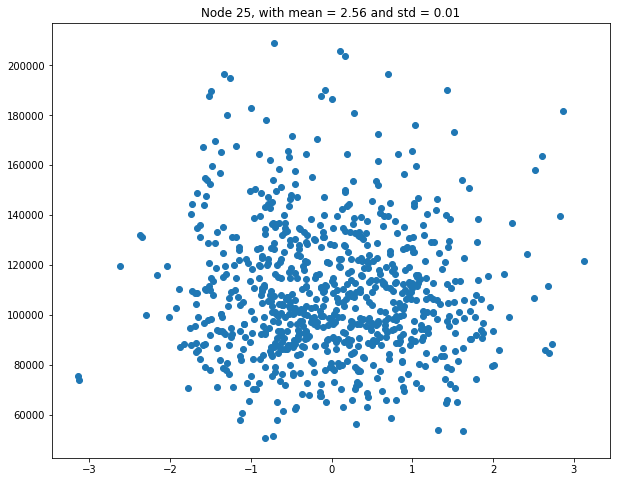

In [193]:
ax = plt.figure(figsize=(10,8))
idx = np.arange(36).reshape(6,6)
i = 4
j = 1
plt.scatter(st_think[:, idx[i,j]], wdeg[:,idx[i,j]]);
plt.title('Node ' + str(idx[i,j]) + ', with mean = ' + str(mean_think[idx[i,j]]) + ' and std = ' + str(std_think[idx[i,j]]))
plt.savefig('roi_thick_to_wdeg_8')

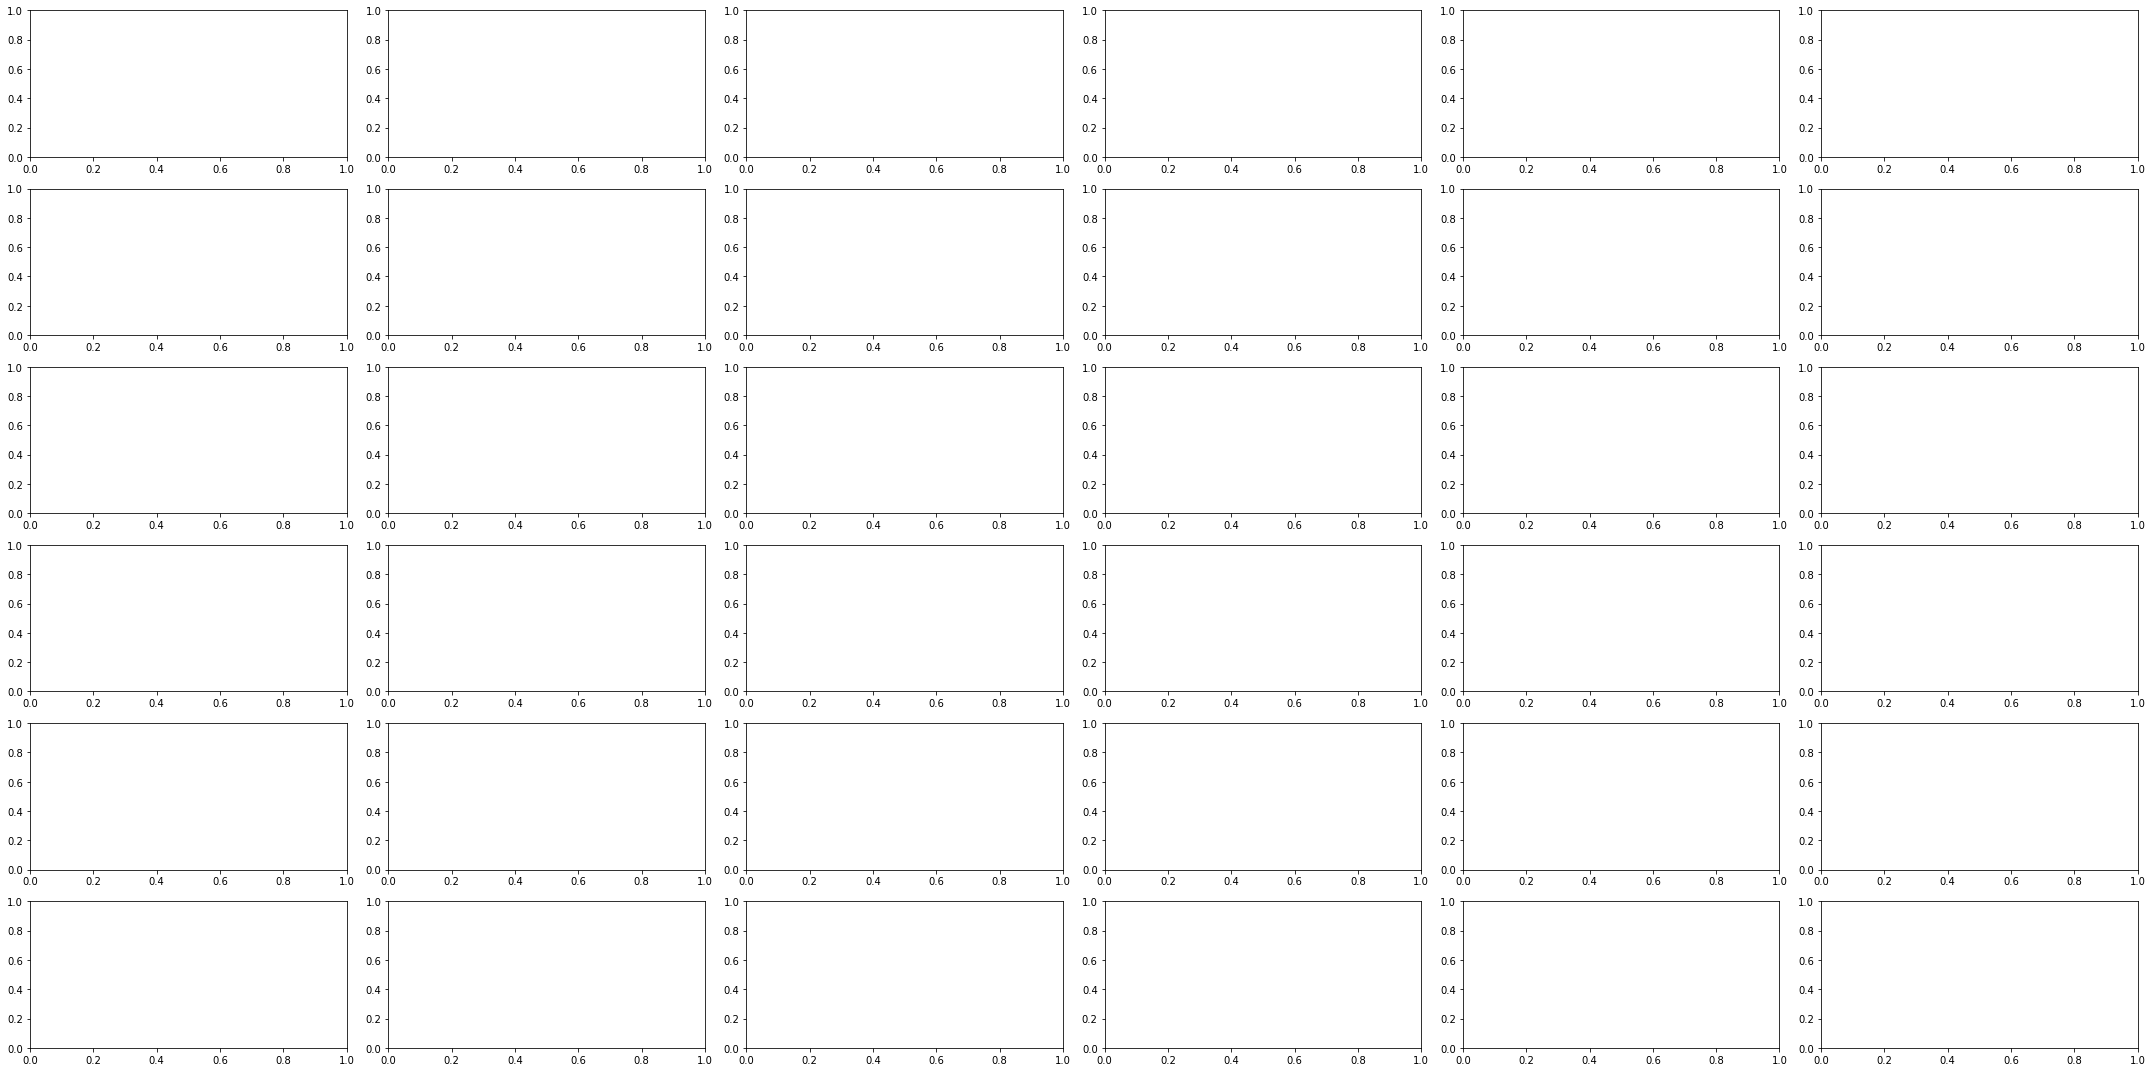

In [114]:
new_idx = np.where(c == 1)[0]
fig, ax = plt.subplots(6,6, figsize = (30,15))
for i in range(6,6):
    for j in range(6,6):
        if i == 5:
            if j == 4:
                break
        ax[i-2, j-2].scatter(st_think[:, idx[i,j]], wdeg[:,idx[i,j]])
        ax[i-2, j-2].set_title('Node ' + str(idx[i,j]) + ', with mean = ' + str(mean_think[idx[i,j]]) + 'and std = ' + str(std_think[idx[i,j]]))
        ax[i-2, j-2].set_xlabel('st thick for ' + str(idx[i,j]) + 'node')
        ax[i-2, j-2].set_ylabel('wdegree node ' + str(idx[i,j]))
        ax[i-2, j-2].set_xlim([min_st_think, max_st_think])
        ax[i-2, j-2].set_ylim([min_wdeg, 200000])
plt.tight_layout()
plt.savefig( 'thinkness_to_wdeg', dpi = 200)

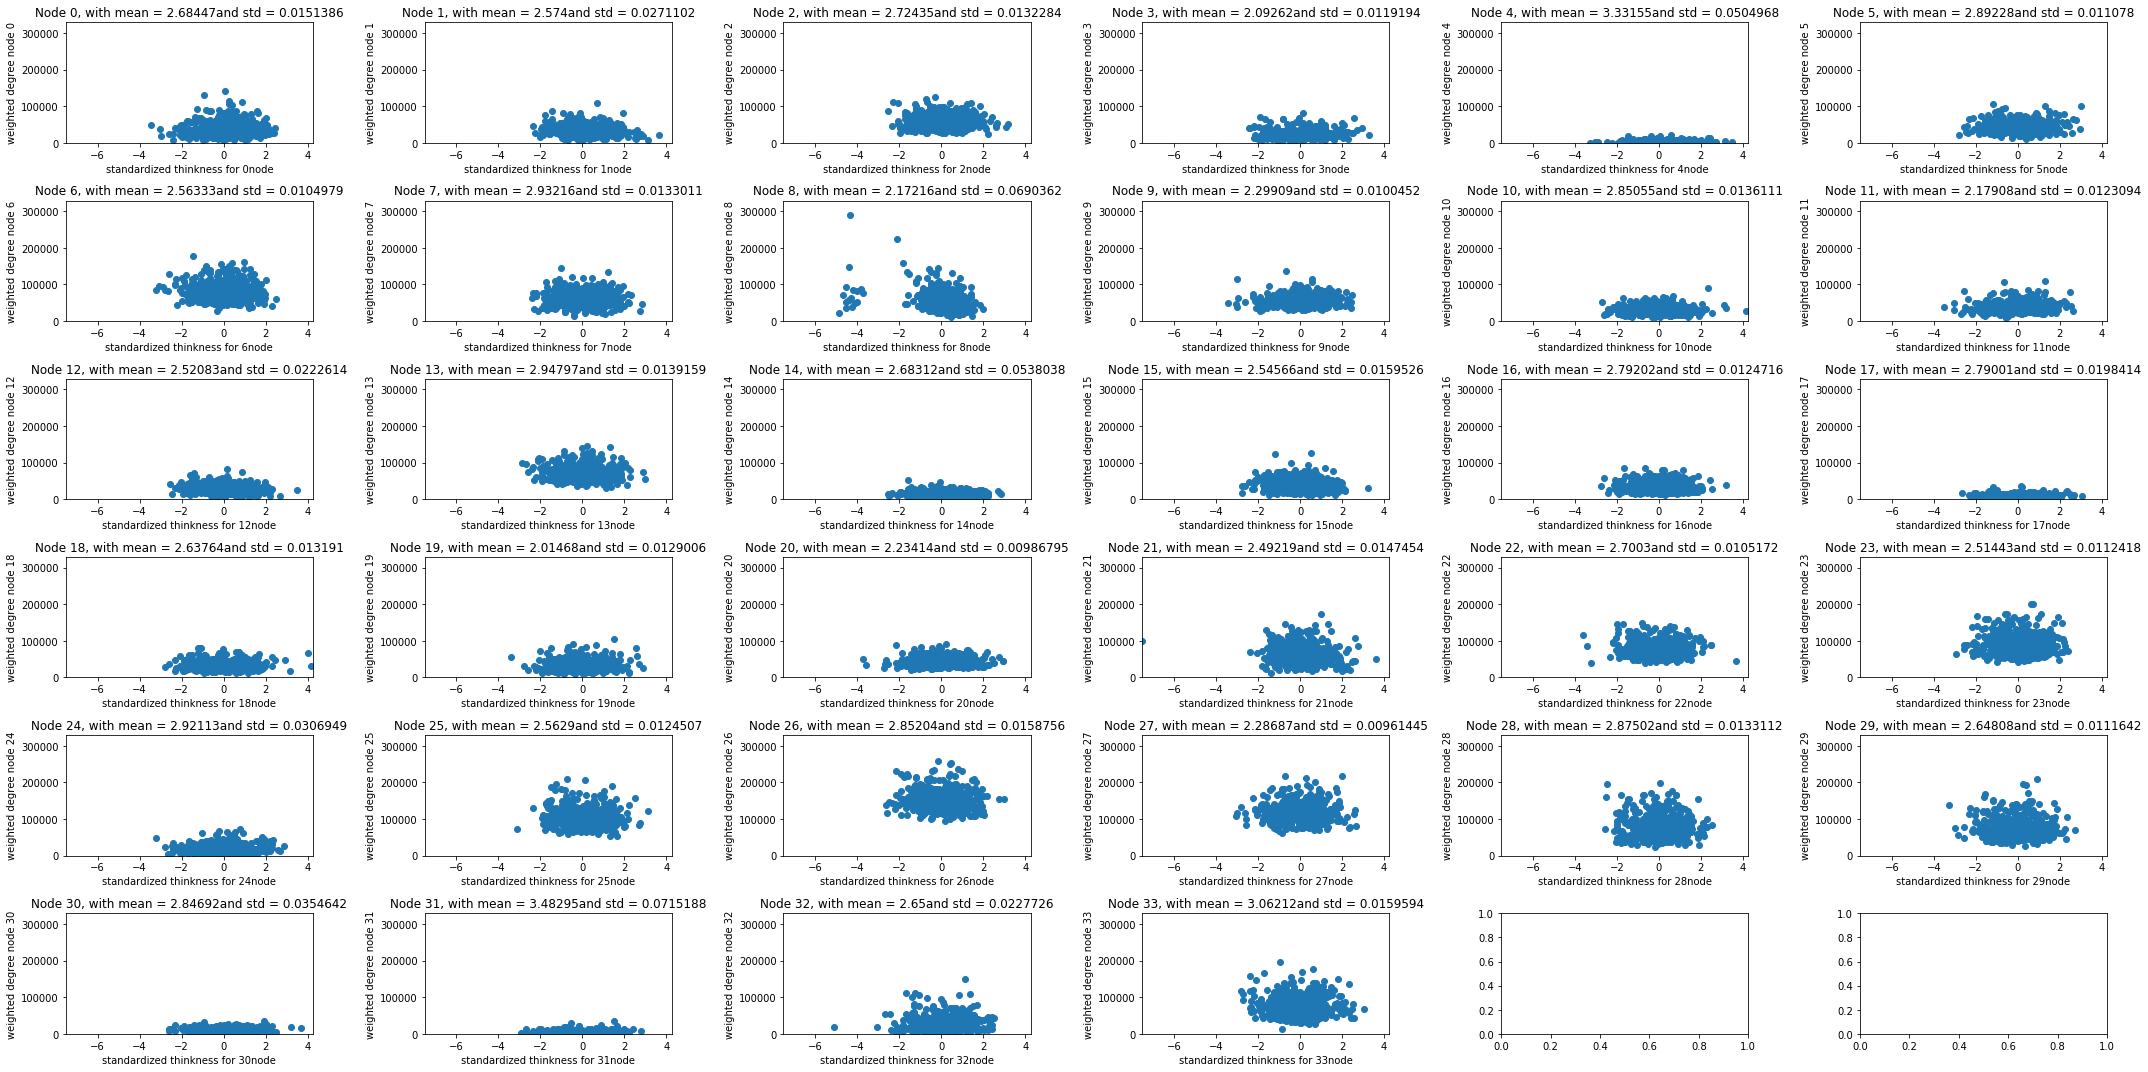

In [56]:
new_idx = np.where(c == 0)[0]
fig, ax = plt.subplots(6,6, figsize = (30,15))
for i in range(6):
    for j in range(6):
        if i == 5:
            if j == 4:
                break
        ax[i, j].scatter(st_think[np.ix_(new_idx), idx[i,j]], wdeg[np.ix_(new_idx),idx[i,j]])
        ax[i, j].set_title('Node ' + str(idx[i,j]) + ', with mean = ' + str(mean_think[idx[i,j]]) + 'and std = ' + str(std_think[idx[i,j]]))
        ax[i, j].set_xlabel('standardized thinkness for ' + str(idx[i,j]) + 'node')
        ax[i, j].set_ylabel('weighted degree node ' + str(idx[i,j]))
        ax[i, j].set_xlim([min_st_think, max_st_think])
        ax[i, j].set_ylim([min_wdeg, max_wdeg])
plt.tight_layout()
plt.savefig( 'woman_thinkness_to_wdeg', dpi = 500)

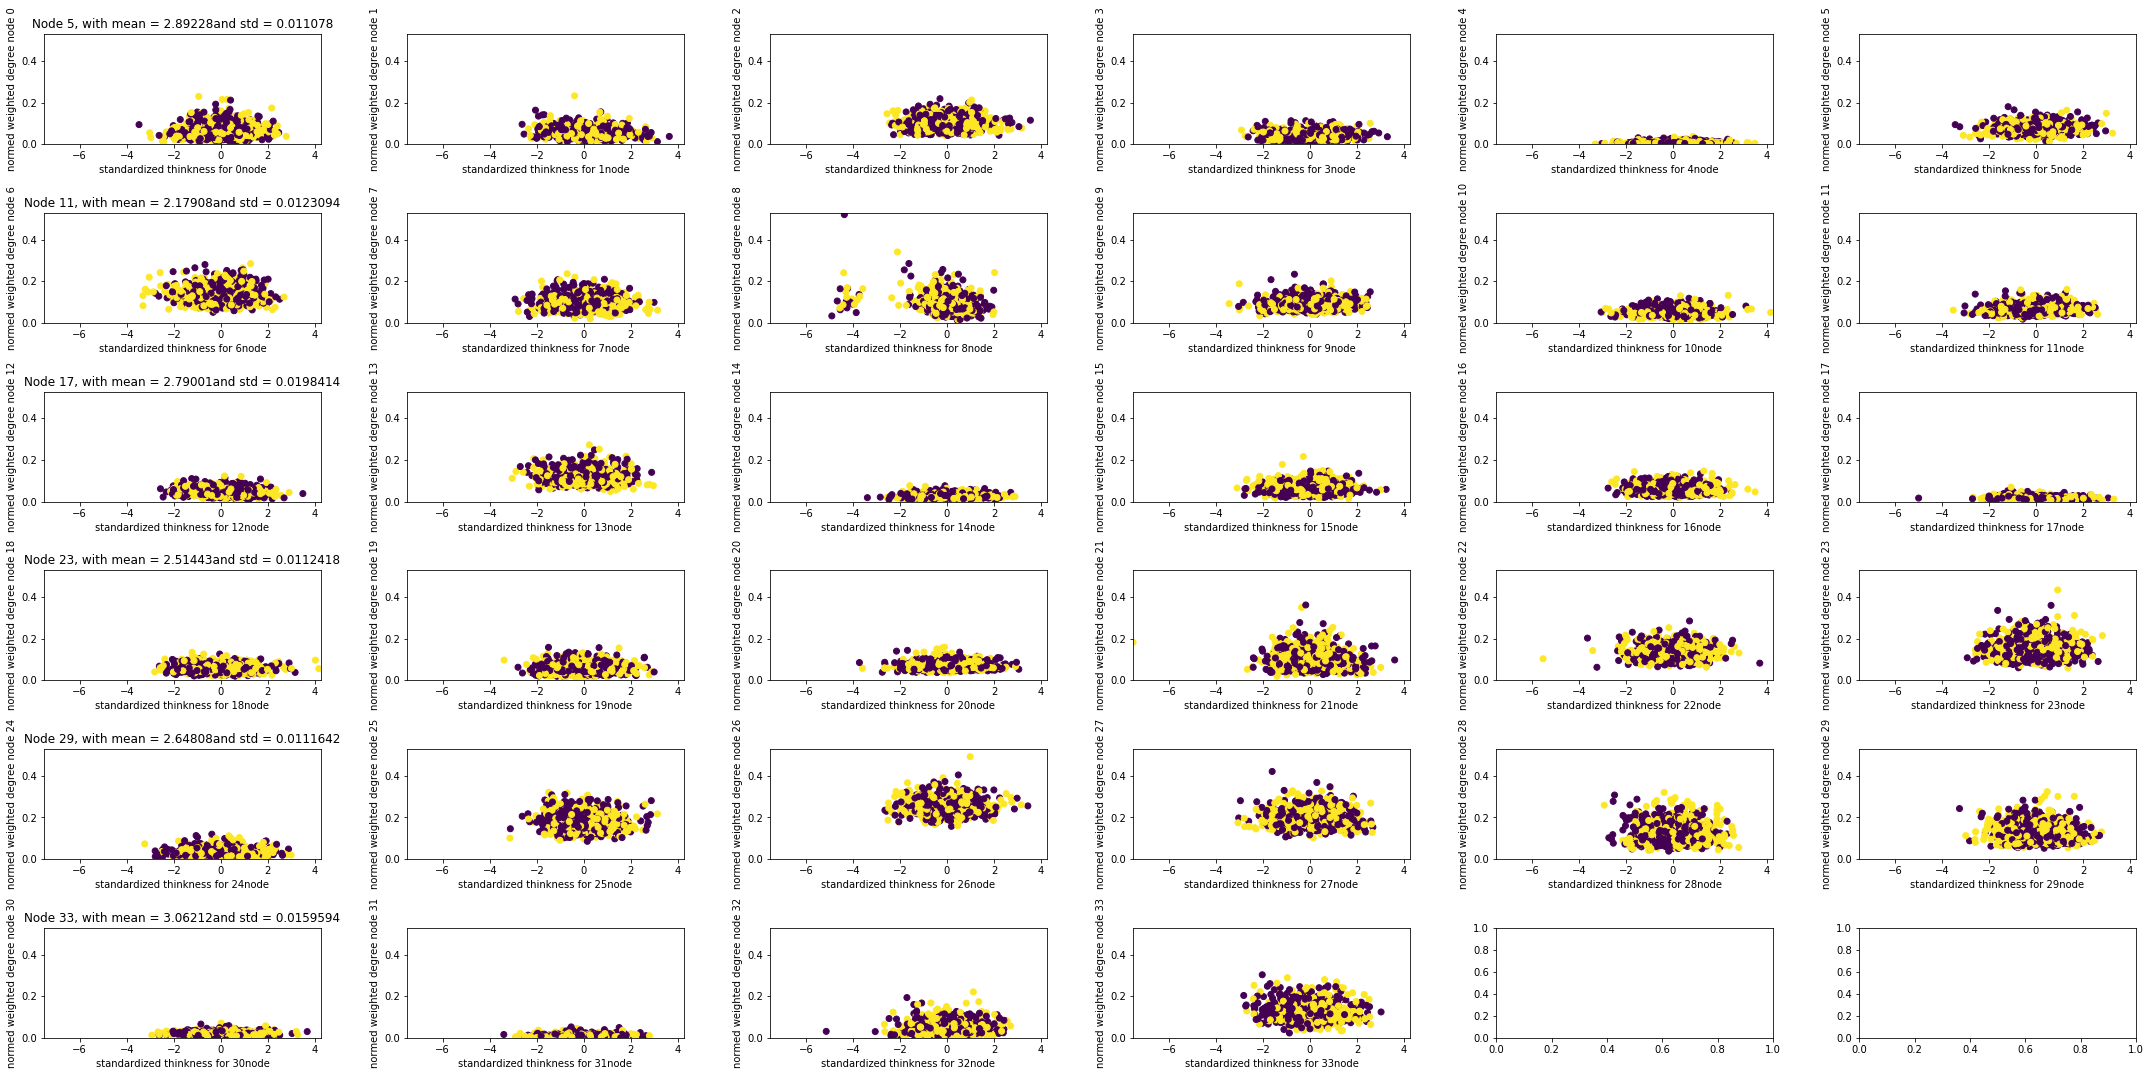

In [46]:
fig, ax = plt.subplots(6,6, figsize = (30,15))
for i in range(6):
    for j in range(6):
        if i == 5:
            if j == 4:
                break
        ax[i, j].scatter(st_think[np.ix_(subj_idx_un), idx[i,j]], norm_wdeg[np.ix_(subj_idx_un),idx[i,j]], c= c)
    #     ax[i, 1].scatter(st_think[:, 34 + i], norm_wdeg[:, 34+i])
        ax[i, 0].set_title('Node ' + str(idx[i,j]) + ', with mean = ' + str(mean_think[idx[i,j]]) + 'and std = ' + str(std_think[idx[i,j]]))

        ax[i, j].set_xlabel('standardized thinkness for ' + str(idx[i,j]) + 'node')
        ax[i, j].set_ylabel('normed weighted degree node ' + str(idx[i,j]))
        ax[i, j].set_xlim([min_st_think, max_st_think])
        ax[i, j].set_ylim([min_norm_wdeg, max_norm_wdeg])
plt.tight_layout()
plt.savefig('thinkness_to_norm_wdeg', dpi = 500)

# AREA

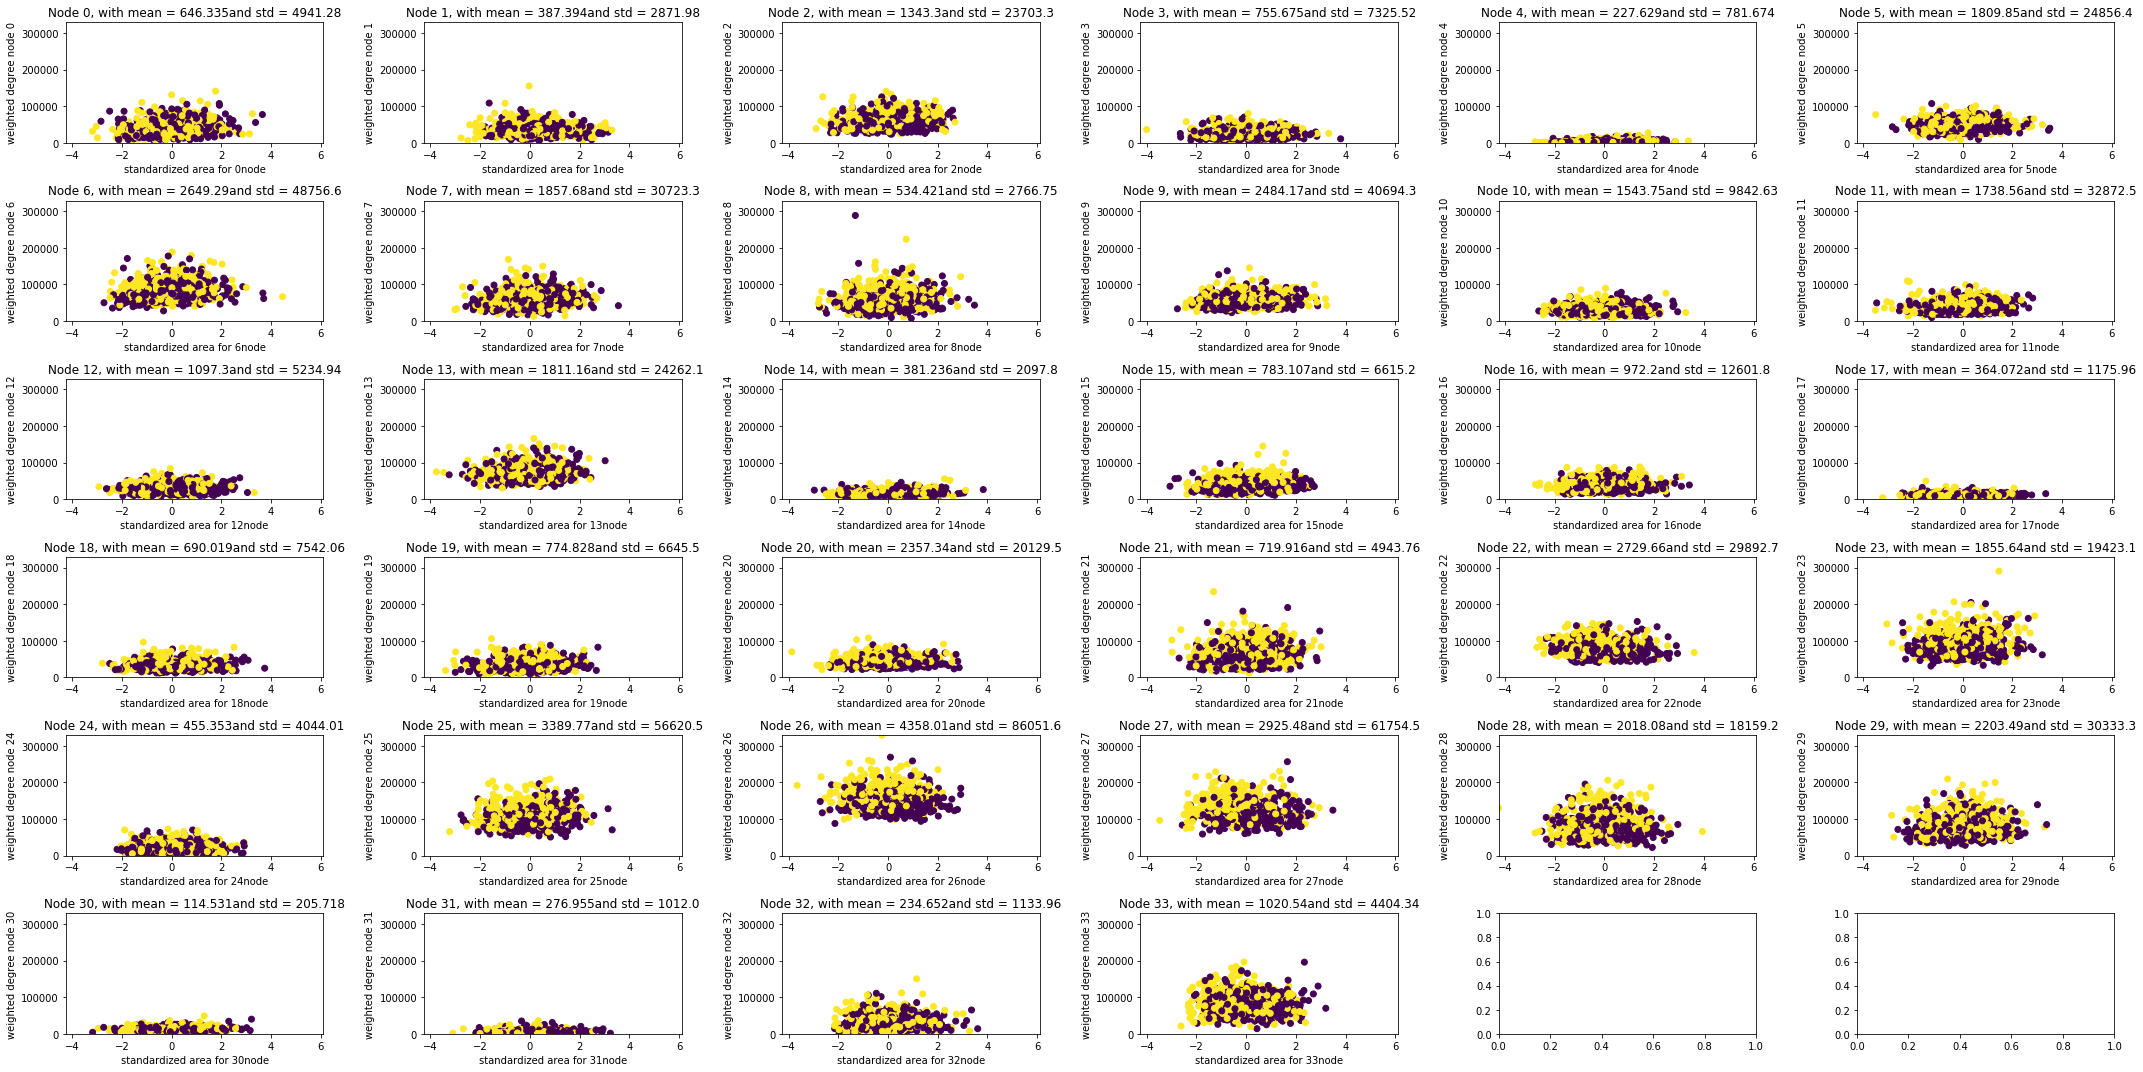

In [49]:
fig, ax = plt.subplots(6,6, figsize = (30,15))
for i in range(6):
    for j in range(6):
        if i == 5:
            if j == 4:
                break   
        ax[i, j].scatter(st_area[np.ix_(subj_idx_un), idx[i,j]], wdeg[np.ix_(subj_idx_un),idx[i,j]], c= c)
    #    ax[i, 1].scatter(st_area[:, 34 + i], wdeg[:, 34+i])
        ax[i, j].set_title('Node ' + str(idx[i,j]) + ', with mean = ' + str(mean_area[idx[i,j]]) + 'and std = ' + str(std_area[idx[i,j]]))

    #    ax[i, 1].set_title('Node ' + str(34 + i) + ', with mean = ' + str(mean_area[34 +i]) +'and std = ' + str(std_area[34 + i]))
        ax[i, j].set_xlabel('standardized area for ' + str(idx[i,j]) + 'node')
        ax[i, j].set_ylabel('weighted degree node ' + str(idx[i,j]))
    #    ax[i, 1].set_xlabel('standardized area for ' + str(34 + i) + 'node')
    #    ax[i, 1].set_ylabel('weighted degree node' + str(34 + i))
        ax[i, j].set_xlim([min_st_area, max_st_area])
        ax[i, j].set_ylim([min_wdeg, max_wdeg])
    #    ax[i, 1].set_xlim([min_st_area, max_st_area])
    #    ax[i, 1].set_ylim([min_wdeg, max_wdeg])
plt.tight_layout()
plt.savefig('area_to_wdeg', dpi = 500)

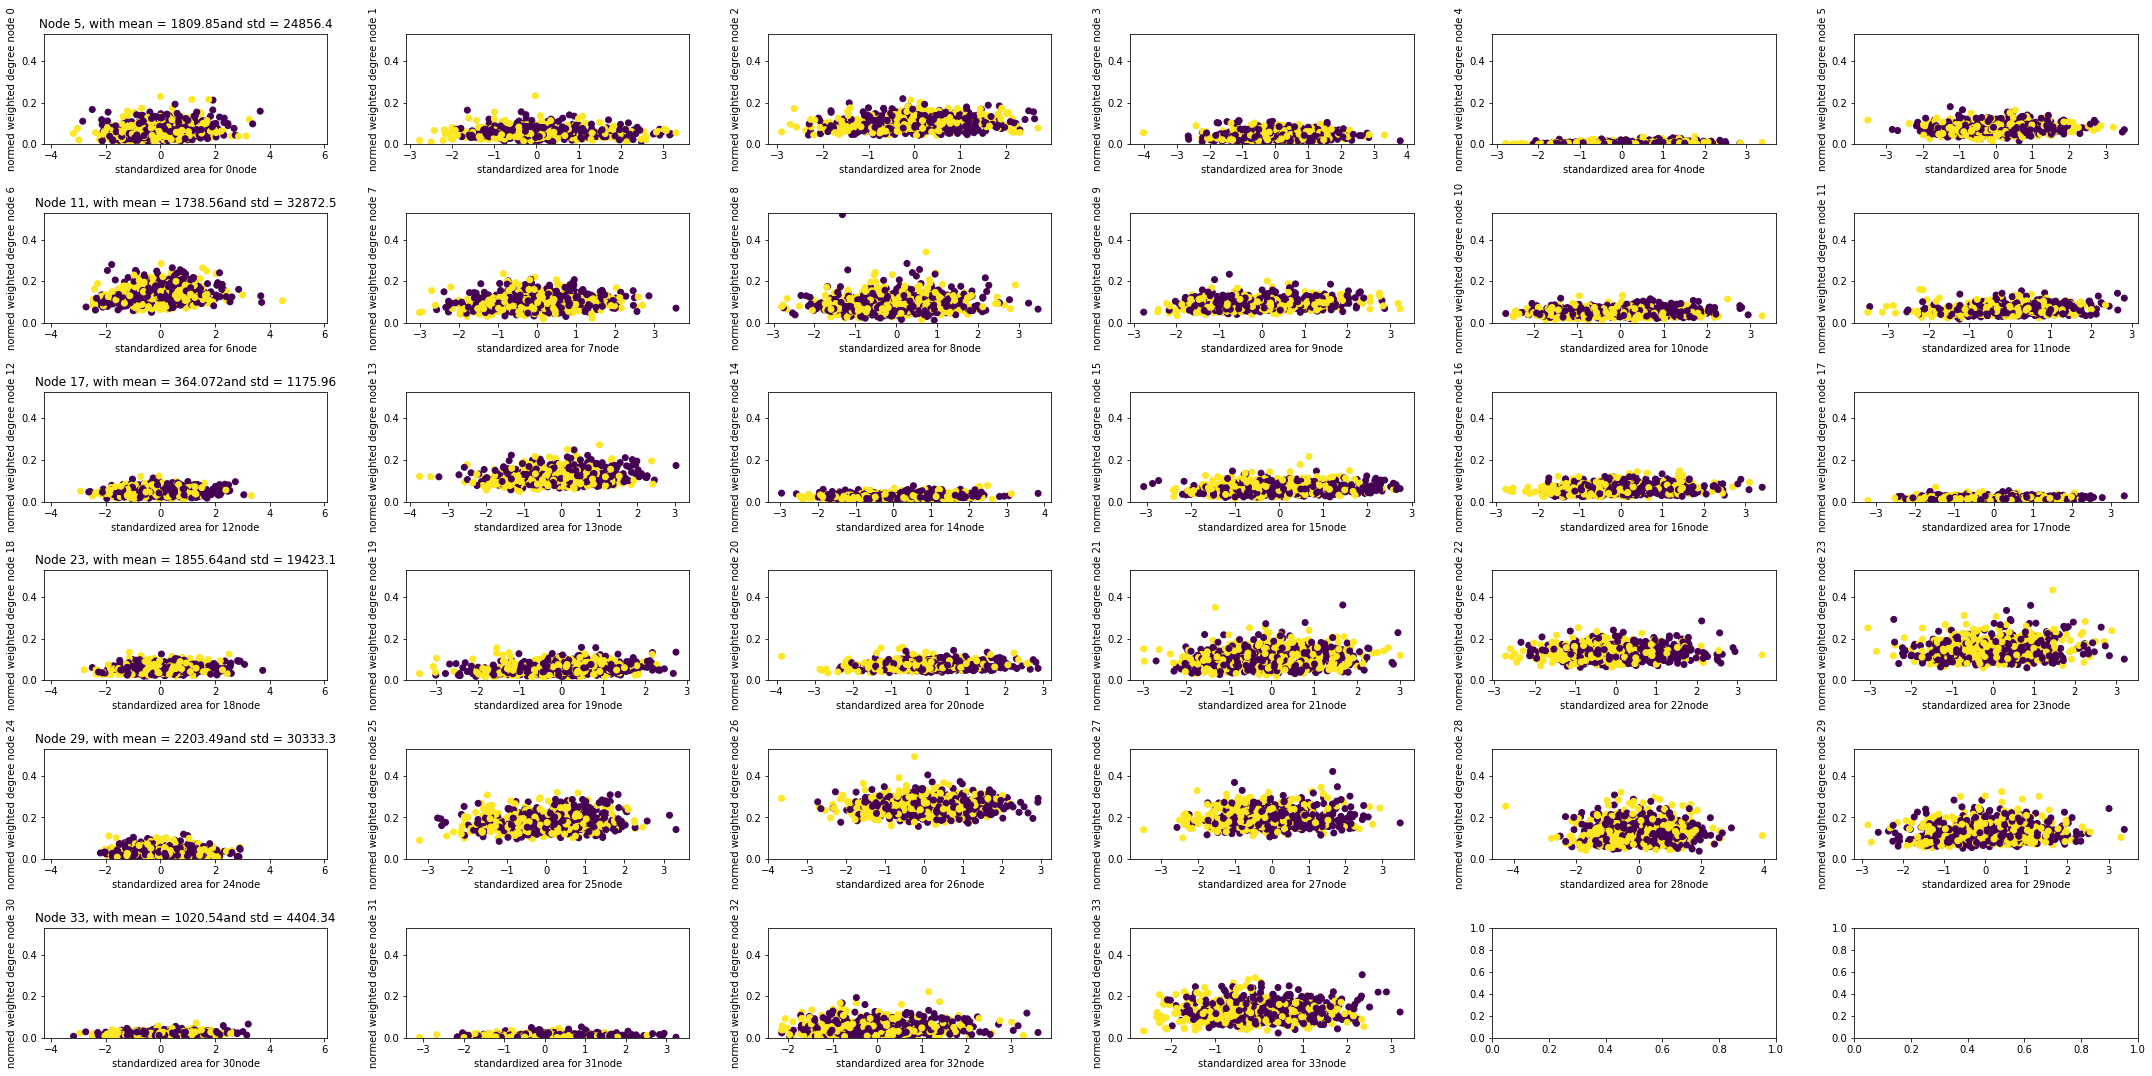

In [50]:
fig, ax = plt.subplots(6,6, figsize = (30,15))
for i in range(6):
    for j in range(6):
        if i == 5:
            if j == 4:
                break   
    
        ax[i, j].scatter(st_area[np.ix_(subj_idx_un), idx[i,j]], norm_wdeg[np.ix_(subj_idx_un),idx[i,j]], c= c)
        #ax[i, 1].scatter(st_area[:, 34 + i], norm_wdeg[:, 34+i])
        ax[i, 0].set_title('Node ' + str(idx[i,j]) + ', with mean = ' + str(mean_area[idx[i,j]]) + 'and std = ' + str(std_area[idx[i,j]]))

       #ax[i, 1].set_title('Node ' + str(34 + i) + ', with mean = ' + str(mean_area[34 +i]) +'and std = ' + str(std_area[34 + i]))
        ax[i, j].set_xlabel('standardized area for ' + str(idx[i,j]) + 'node')
        ax[i, j].set_ylabel('normed weighted degree node ' + str(idx[i,j]))
        #ax[i,j1].set_xlabel('standardized area for ' + str(34 + i) + 'node')
        #ax[i, 1].set_ylabel('normed weighted degree node' + str(34 + i))
        ax[i, 0].set_xlim([min_st_area, max_st_area])
        ax[i, j].set_ylim([min_norm_wdeg, max_norm_wdeg])
        #ax[i,j1].set_xlim([min_st_area, max_st_area])
        #ax[i, 1].set_ylim([min_norm_wdeg, max_norm_wdeg])
plt.tight_layout()
plt.savefig('area_to_norm_wdeg', dpi = 500)

# VOLUME

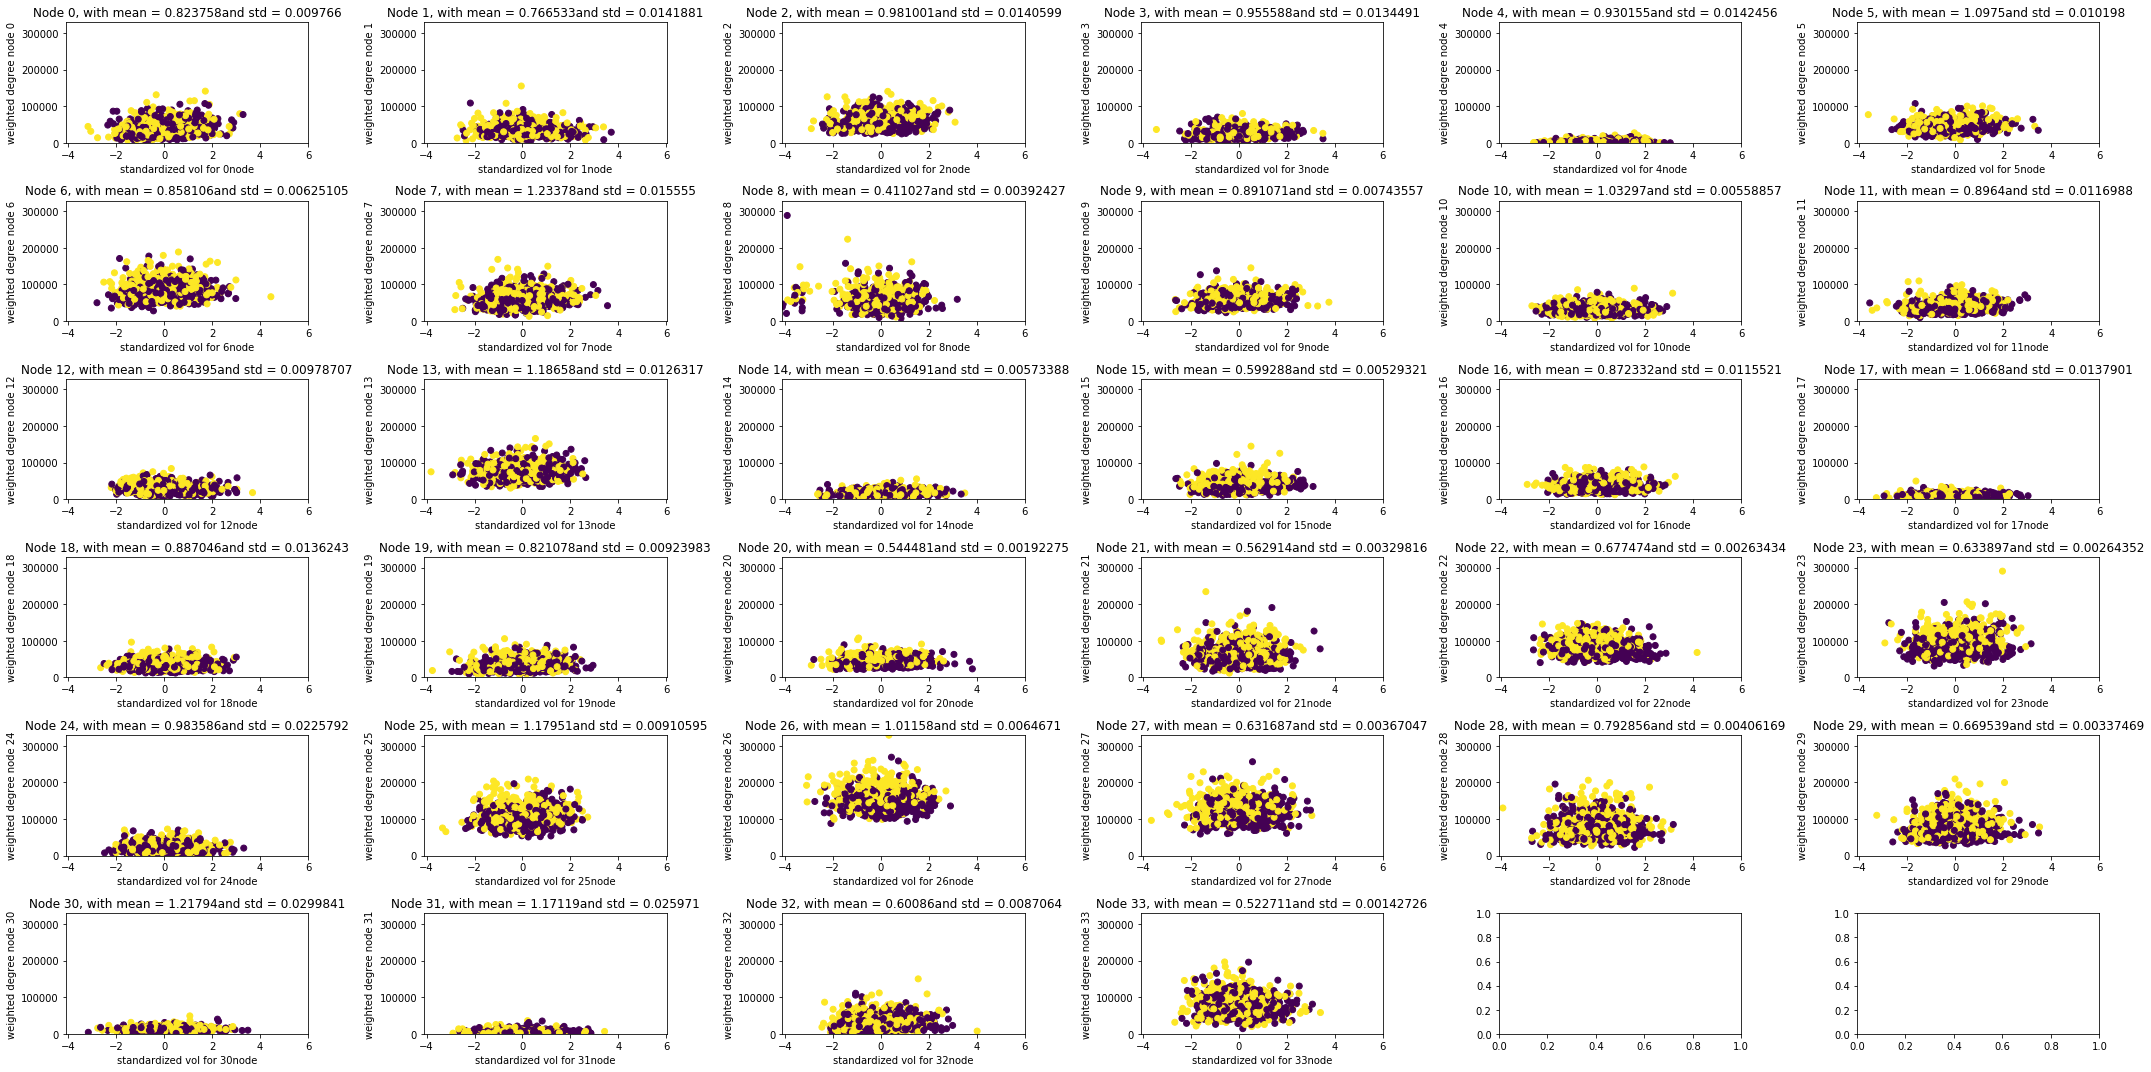

In [51]:
fig, ax = plt.subplots(6,6, figsize = (30,15))
for i in range(6):
    for j in range(6):
        if i == 5:
            if j == 4:
                break   

        ax[i, j].scatter(st_vol[np.ix_(subj_idx_un), idx[i,j]], wdeg[np.ix_(subj_idx_un),idx[i,j]], c= c)
        #ax[i, 1].scatter(st_vol[:, 34 + i], wdeg[:, 34+i])
        ax[i, j].set_title('Node ' + str(idx[i,j]) + ', with mean = ' + str(mean_vol[idx[i,j]]) + 'and std = ' + str(std_vol[idx[i,j]]))

        #ax[i, 1].set_title('Node ' + str(34 + i) + ', with mean = ' + str(mean_vol[34 +i]) +'and std = ' + str(std_vol[34 + i]))
        ax[i, j].set_xlabel('standardized vol for ' + str(idx[i,j]) + 'node')
        ax[i, j].set_ylabel('weighted degree node ' + str(idx[i,j]))
        #ax[i, 1].set_xlabel('standardized vol for ' + str(34 + i) + 'node')
        #ax[i, 1].set_ylabel('weighted degree node' + str(34 + i))
        ax[i, j].set_xlim([min_st_vol, max_st_vol])
        ax[i, j].set_ylim([min_wdeg, max_wdeg])
        #ax[i, 1].set_xlim([min_st_vol, max_st_vol])
        #ax[i, 1].set_ylim([min_wdeg, max_wdeg])
plt.tight_layout()
plt.savefig('vol_to_wdeg', dpi = 500)

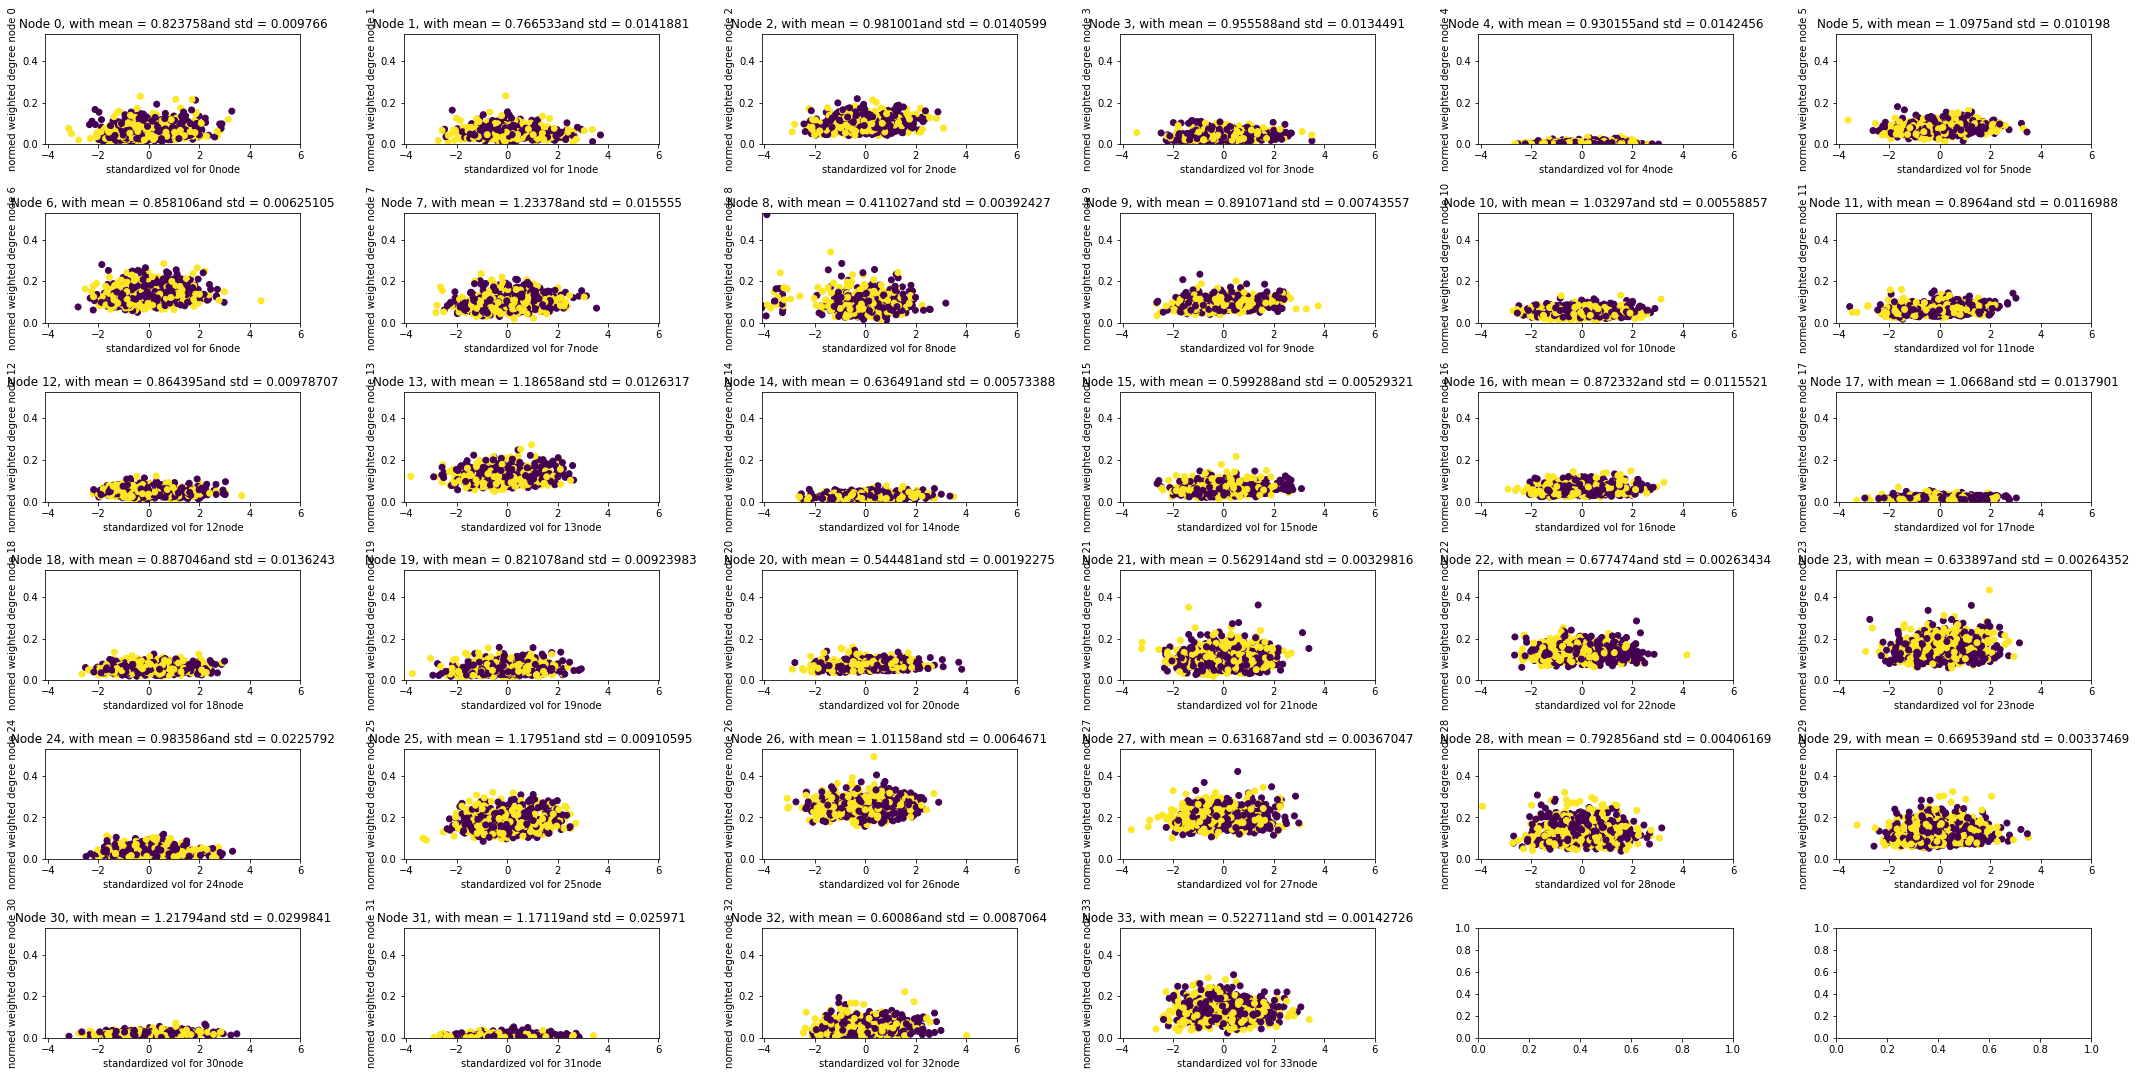

In [52]:
fig, ax = plt.subplots(6,6, figsize = (30,15))
for i in range(6):
    for j in range(6):
        if i == 5:
            if j == 4:
                break   

        ax[i, j].scatter(st_vol[np.ix_(subj_idx_un), idx[i,j]], norm_wdeg[np.ix_(subj_idx_un),idx[i,j]], c= c)
        #ax[i, 1].scatter(st_vol[:, 34 + i], norm_wdeg[:, 34+i])
        ax[i, j].set_title('Node ' + str(idx[i,j]) + ', with mean = ' + str(mean_vol[idx[i,j]]) + 'and std = ' + str(std_vol[idx[i,j]]))

        #ax[i, 1].set_title('Node ' + str(34 + i) + ', with mean = ' + str(mean_vol[34 +i]) +'and std = ' + str(std_vol[34 + i]))
        ax[i, j].set_xlabel('standardized vol for ' + str(idx[i,j]) + 'node')
        ax[i, j].set_ylabel('normed weighted degree node ' + str(idx[i,j]))
        #ax[i, 1].set_xlabel('standardized vol for ' + str(34 + i) + 'node')
        #ax[i, 1].set_ylabel('normed weighted degree node' + str(34 + i))
        ax[i, j].set_xlim([min_st_vol, max_st_vol])
        ax[i, j].set_ylim([min_norm_wdeg, max_norm_wdeg])
        #ax[i, 1].set_xlim([min_st_vol, max_st_vol])
        #ax[i, 1].set_ylim([min_norm_wdeg, max_norm_wdeg])
plt.tight_layout()
plt.savefig('vol_to_norm_wdeg', dpi = 500)

# all meshes to global

In [1]:
import numpy as np
import pandas as pd
import pickle

import os

from flexible_linear import FlexibleLinearRegression

from tv_utils import CustomTVReg, integration_mesh_to_tria, get_meshes_coord_tria, get_nodes_attribute
from data_load import load_meshes_coor_tria

from joblib import Parallel, delayed

from tv_utils import get_all_attr

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV


path_data = "/nmnt/x01-hdd/HCP/data/"

with open(path_data + "mean_mesh_labels", 'rb') as f:
    mean_labels = pickle.load(f)

with open(path_data + "subjects_log_jac", 'rb') as f:
    log_jac = pickle.load(f)

with open(path_data + "subjects_thinkness", 'rb') as f:
    thinkness = pickle.load(f)

with open(path_data + "subjects_mesh_area", 'rb') as f:
    mesh_area = pickle.load(f)

with open(path_data + 'modularity', 'rb') as f:
    modularity = pickle.load(f)

    
thinkness = thinkness.reshape(789,-1)
log_jac = log_jac.reshape(789,-1)
mesh_area = mesh_area.reshape(789,-1)


path_res = '/home/ayagoz/connec/results/'
                   

coord, tria = load_meshes_coor_tria(path_data)

X = integration_mesh_to_tria(tria, thinkness)
X.shape

custom_tvl2 = CustomTVReg(data = tria, mode_reg= 'l2')
flexl2 = FlexibleLinearRegression(C=1e-8, reg_cost_func=custom_tvl2.tv_normed_cost_func)

path_res = '/nmnt/media/home/ayagoz/HCP/connec/results/tv/all_meshes_to_global/'


import time

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
st = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, modularity)
flexl2.fit(X_train, y_train)
print(time.time() - st)
r2_test = r2_score(y_test, flexl2.predict(X_test))
r2_train = r2_score(y_train, flexl2.predict(X_train))
data = pd.DataFrame(data =[r2_train, r2_test], columns=['train', 'test'])
data.to_csv(path_res + 'flexl2')

In [27]:
from sklearn.preprocessing import StandardScaler

In [57]:
i = 0

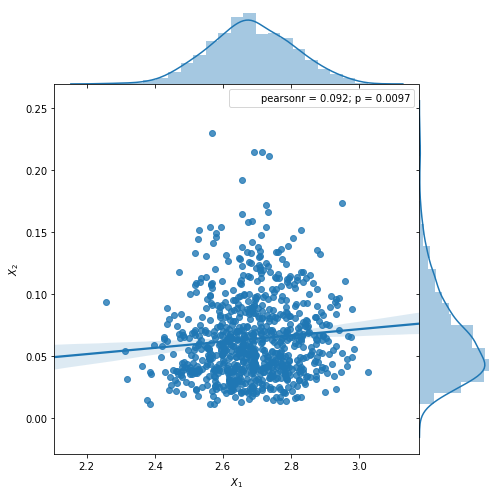

In [58]:

x1 = pd.Series(roi_think[:,i], name="$X_1$")
x2 = pd.Series(Y.sum(axis = -1)[:,i], name="$X_2$")

# Show the joint distribution using kernel density estimation
g = sns.jointplot(x1, x2, kind="reg", size=7, space=0)

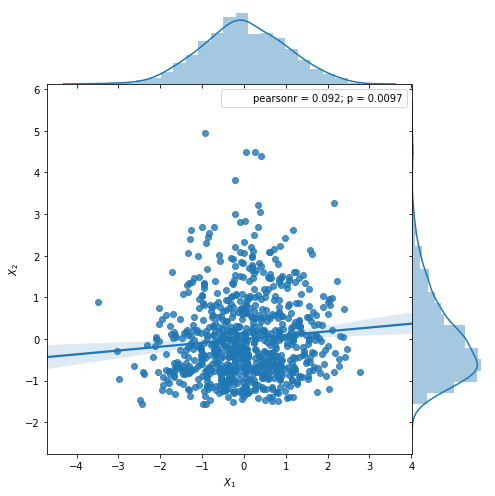

In [59]:
sc = StandardScaler()
st_roi_think = sc.fit_transform(roi_think)
st_wdeg = sc.fit_transform(Y.sum(axis = -1))
x1 = pd.Series(st_roi_think[:,i], name="$X_1$")
x2 = pd.Series(st_wdeg[:,i], name="$X_2$")

# Show the joint distribution using kernel density estimation
g = sns.jointplot(x1, x2, kind="reg", size=7, space=0)

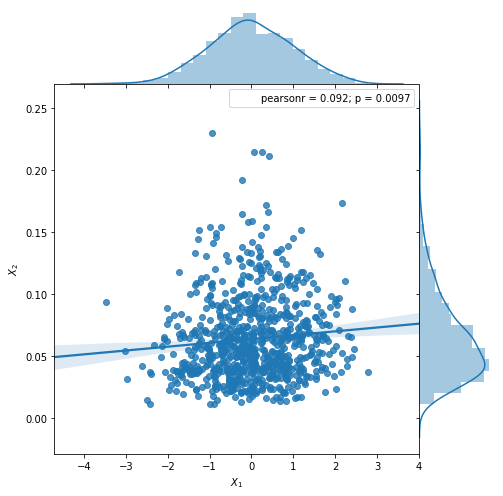

In [60]:
sc = StandardScaler()
st_roi_think = sc.fit_transform(roi_think)
st_wdeg = sc.fit_transform(Y.sum(axis = -1))
x1 = pd.Series(st_roi_think[:,i], name="$X_1$")
x2 = pd.Series(Y.sum(axis = -1)[:,i], name="$X_2$")

# Show the joint distribution using kernel density estimation
g = sns.jointplot(x1, x2, kind="reg", size=7, space=0)

In [72]:
data1 = pd.DataFrame(data = roi_think, columns=['roi_think' + str(i) for i in range(68)])
data2 = pd.DataFrame(data =  Y.sum(axis = -1), columns=['wdeg' + str(i) for i in range(68)])
data = pd.concat([data1,data2], axis = 1)


In [74]:
sns.pairplot(data, kind = 'reg', x_vars=['roi_think' + str(i) for i in range(68)], 
             y_vars=['wdeg' + str(i) for i in range(68)])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


30


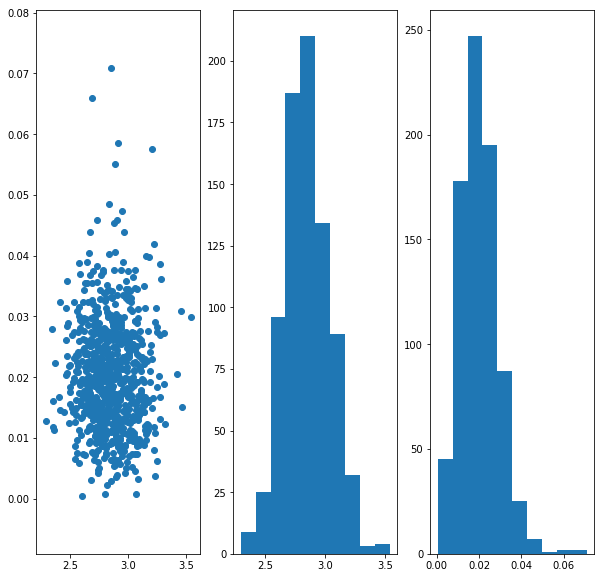

In [52]:
fig, ax = plt.subplots(1,3, figsize = (10,10))
i = np.random.randint(0, 68)
print(i)
ax[0].scatter(roi_think[:,i], Y.sum(axis = -1)[:,i])
ax[1].hist(roi_think[:,i])
ax[2].hist(Y.sum(axis = -1)[:,i]);

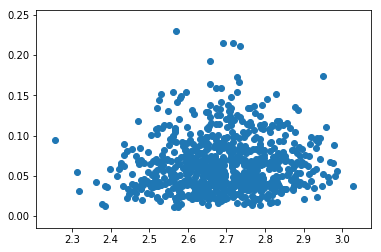

In [7]:
i = 0
plt.scatter(roi_think[:,i], Y.sum(axis = -1)[:,i]);

48


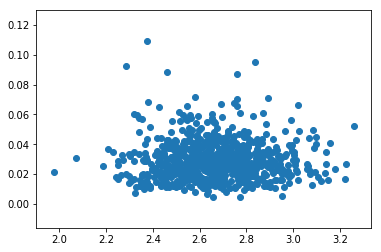

In [8]:
i = np.random.randint(0, 68)
print(i)
plt.scatter(roi_think[:,i], Y.sum(axis = -1)[:,i]);

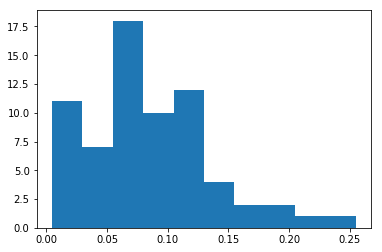

In [12]:
plt.hist(Y.sum(axis = -1).mean(axis = 0));

17


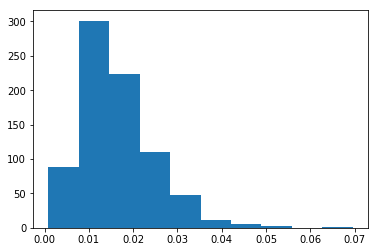

In [15]:
i = np.random.randint(0,68)
print(i)
plt.hist(Y.sum(axis = -1)[:,i]);

In [ ]:
fig, ax = plt.subplots(10,1, figsize = (200,180))
for i in range(10):
    ax[i].scatter(roi_think[:,i], Y.sum(axis = -1)[:,i])

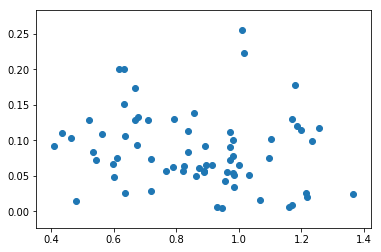

In [7]:
plt.scatter(roi_vol.mean(axis = 0), Y.sum(axis = -1).mean(axis = 0))

In [2]:
path_res = '/nmnt/media/home/ayagoz/HCP/connec/results/'
if not os.path.exists(path_res):
    os.mkdir(path_res)
path_res += 'tv/'
if not os.path.exists(path_res):
    os.mkdir(path_res)

In [3]:
path_res

'/nmnt/media/home/ayagoz/HCP/connec/results/tv/'

In [4]:
if not os.path.exists(path_res + 'node_to_node'):
    os.mkdir(path_res + 'node_to_node')
path_res += 'node_to_node/'

thinkness = thinkness.reshape(789,-1)
log_jac = log_jac.reshape(789,-1)
mesh_area = mesh_area.reshape(789,-1)

idx_nodes = list(range(1,4)) + list(range(5,39)) + list(range(40,71))
idx_nodes = np.array(idx_nodes)
print(idx_nodes.shape)
X = []
triangles = []
for i in range(68):
    node1 = idx_nodes[i]
    print(i)
    node1_tria = get_meshes_coord_tria(tria, mean_labels, node1)
    print(np.array(node1_tria).shape)
    triangles += [node1_tria] 
    T = integration_mesh_to_tria(node1_tria, thinkness)
    L = integration_mesh_to_tria(node1_tria, log_jac)
    M = integration_mesh_to_tria(node1_tria, mesh_area)
    X += [[T,L,M]]
    
print('I am here')

(68,)
0
(4015, 3)
1
(2598, 3)
2
(7167, 3)
3
(3086, 3)
4
(1421, 3)
5
(9167, 3)
6
(15365, 3)
7
(8516, 3)
8
(5598, 3)
9
(12392, 3)
10
(8057, 3)
11
(8116, 3)
12
(6253, 3)
13
(8617, 3)
14
(3029, 3)
15
(6368, 3)
16
(5901, 3)
17
(1763, 3)
18
(3885, 3)
19
(3591, 3)
20
(18418, 3)
21
(6358, 3)
22
(20975, 3)
23
(14240, 3)
24
(2575, 3)
25
(14289, 3)
26
(23890, 3)
27
(20503, 3)
28
(14128, 3)
29
(16869, 3)
30
(468, 3)
31
(1499, 3)
32
(1939, 3)
33
(11399, 3)
34
(4125, 3)
35
(3146, 3)
36
(6794, 3)
37
(3129, 3)
38
(1196, 3)
39
(8967, 3)
40
(18953, 3)
41
(8080, 3)
42
(5270, 3)
43
(11632, 3)
44
(8609, 3)
45
(7565, 3)
46
(5335, 3)
47
(9778, 3)
48
(2699, 3)
49
(7365, 3)
50
(4731, 3)
51
(1755, 3)
52
(4531, 3)
53
(3438, 3)
54
(17671, 3)
55
(5803, 3)
56
(20889, 3)
57
(15575, 3)
58
(1979, 3)
59
(15401, 3)
60
(23388, 3)
61
(19997, 3)
62
(13309, 3)
63
(15948, 3)
64
(674, 3)
65
(1371, 3)
66
(1414, 3)
67
(12168, 3)
I am here


In [29]:
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']
d = sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)


In [54]:


name = ['think/', 'log_jac/', 'mesh_area/']
params = {'C':[1e-8],
         'cost_func': ['l2',]}


def main_worker(i, data, target, j, trian):
    node1 = idx_nodes[i]
    print(node1)
    custom_tvl1 = CustomTVReg(data = trian, mode_reg= 'l1')
    custom_tvl2 = CustomTVReg(data = trian, mode_reg= 'l2')

    flexl1 = FlexibleLinearRegression(C=1e-8, reg_cost_func=custom_tvl1.tv_normed_cost_func)
    flexl2 = FlexibleLinearRegression(C=1e-8, reg_cost_func=custom_tvl2.tv_normed_cost_func)
    grl1 = GridSearchCV(flexl1, param_grid=params, n_jobs=-1, scoring='r2', cv = 3)
    grl2 = GridSearchCV(flexl2, param_grid=params, n_jobs=-1, scoring='r2', cv = 3)

    for folder in name:
        if not os.path.exists(path_res + folder):
            os.mkdir(path_res + folder)

    print(data[0].shape, target[:,i].shape)



    for k in range(3):

        grl1.fit(data[k], target[:,i])
        grl2.fit(data[k], target[:,i])
        res_l1 = pd.DataFrame.from_dict(grl1.cv_results_)
        res_l1 = res_l1.sort_values(by = 'rank_test_score').iloc[:1]
        res_l1.to_csv(path_res + name[j] + 'tv_l1')

        res_l2 = pd.DataFrame.from_dict(grl2.cv_results_)
        res_l2 = res_l2.sort_values(by = 'rank_test_score').iloc[:1]
        res_l2.to_csv(path_res + name[j] + 'tv_l2')
    

In [ ]:
for j, target in enumerate(targets_data):
    print(targets_name[j])
    print(target.shape)
    Parallel(n_jobs=28)(delayed(main_worker)(i, target, j, triangles[i]) for i in range(68))
    print('Finished work for ' + targets_name[j])
print('I finished all')

In [55]:
%timeit
Parallel(n_jobs=1)(delayed(main_worker)(i, X[i] targets_data[i], i, triangles[i]) for i in range(1))

1
(789, 4015) (789,)


[None]

In [138]:
name = ['think/', 'log_jac/', 'mesh_area/']
params = {'C':[5*1e-5, ], 
         'cost_func': ['l2']}

custom_tvl2 = CustomTVReg(data = triangles[64], mode_reg= 'l2')
flexl2 = FlexibleLinearRegression(C=1e-8, reg_cost_func=custom_tvl2.tv_normed_cost_func)
grl2 = GridSearchCV(flexl2, param_grid=params, n_jobs=1, scoring='r2', cv = 2)

path_res = '/nmnt/media/home/ayagoz/HCP/connec/results/tv/node_to_node/'

for folder in name:
    if not os.path.exists(path_res + folder):
        os.mkdir(path_res + folder)

print(np.array(X[64]).shape, targets_data[0].shape)

import time

st = time.time()
grl2.fit(X[64][0], targets_data[0][:,64])

res_l2 = pd.DataFrame.from_dict(grl2.cv_results_)
    
print(time.time() - st)

In [146]:
res_l2.sort_values(by ='rank_test_score')

mean_fit_time  mean_score_time  mean_test_score  mean_train_score param_C  \
0       0.872842          0.00062        -9.254394         -9.254077   5e-05   

  param_cost_func                           params  rank_test_score  \
0              l2  {'C': 5e-05, 'cost_func': 'l2'}                1   

   split0_test_score  split0_train_score  split1_test_score  \
0          -9.504224            -9.00393           -9.00393   

   split1_train_score  std_fit_time  std_score_time  std_test_score  \
0           -9.504224      0.034681        0.000021        0.250146   

   std_train_score  
0         0.250147